## Marker gene calculation

In this notebook we calculate marker genes for the cell types of the HLCA. We will first calculate the marker genes of our "grouped" annotations, i.e. a slightly coarser version of our final manual annotations. These coarser annotations are used for the mapping of GWAS results to cell types (for which we'll need the marker genes calculated below), and for the modeling of effects of age, sex etc. on HLCA cell types.  
We will also calculate marker genes for the final, finest cell type annotations. For this we will use a more complex approach, as you will see below.

### Import modules and set paths:

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append("../../scripts")
import marker_selection

For pretty code formatting (not necessary to run):

In [2]:
%load_ext lab_black

Figure parameters:

In [3]:
sc.set_figure_params(figsize=(5, 5))

Paths:

In [4]:
path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_man_anns_levd_and_colors = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
dir_pseudobulks = "../../data/HLCA_core_h5ads/pseudobulks"
path_marker_genes = "../../results/markers/markergenes.csv"
dir_figures = "../../results/figures/"

import files incl. atlas:

In [5]:
adata = sc.read(path_HLCA)
ct_reference = pd.read_csv(path_man_anns_levd_and_colors, index_col=0)

create empty dataframe for final markers:

In [6]:
marker_df_final = pd.DataFrame(
    index=range(20),
    columns=sorted(
        [f"{ct}_marker" for ct in ct_reference.index]
        + [f"{ct}_marker_for" for ct in ct_reference.index]
        + [f"{ct}_marker_reference" for ct in ct_reference.index]
    ),
)

Set analysis parameters:

In [7]:
min_n_cells_for_pseudobulk = (
    10  # this is per cell type, per sample (or whatever is pseudobulked)
)
min_n_cells_for_rare_cell_pseudobulk = 3  # use different threshold for very rare cells
rare_cell_threshold = 100  # total number of cells to call a cell type rare

Initiate empty dictionaries to store pseudobulks in:

In [8]:
pbs = dict()  # for actual pseudobulks
pb_adatas_unfilt = dict()  # for pseudobulks converted to anndata objects
pb_adatas = (
    dict()
)  # same as above, but after filtering based on min_n_cells_for_pseudobulk
pbs_fraction_positive = (
    dict()
)  # to store what fraction of cells is positive for each gene, per pseudobulk (useful for filtering, we want broadly expressed markers)
pb_fraction_positive_adatas_unfilt = dict()  # same as above, but as AnnData object
pb_fraction_positive_adatas = (
    dict()
)  # same as pbs_fraction_positive, but after filtering based on min_n_cells_for_pseudobulk,

Choose variables to pseudobulk by:

In [9]:
pb_var_1 = "sample"  # e.g. sample or dataset
pb_var_2 = "manual_ann"  # e.g. manual_ann or ann_level_3
pb_name = f"{pb_var_1}_{pb_var_2}"

## Perform pseudobulking:

(Will skip this part of the code as it takes very long and I already ran it before, comment back in when running for the first time!)

In [10]:
# genes = adata.var.index.tolist()
# counts_df = pd.DataFrame(data=adata.X.toarray(), index=adata.obs.index, columns=genes)
# counts_df_boolean = counts_df > 0

add metadata to counts_df + counts_df_boolean for variables for which we'll need the info later on (after pseudobulking) + pseudobulking variables:

In [11]:
# for obs_cat in [
#     "study",
#     "anatomical_region_level_1",
#     "ann_level_1",
#     pb_var_1,
#     pb_var_2,
# ]:  # ann_level_1 will help with cell counting in groupby function below
#     counts_df[obs_cat] = adata.obs[obs_cat]
#     counts_df_boolean[obs_cat] = adata.obs[obs_cat]

Calculate pseudobulks. Set dictionary with aggregation info:

In [12]:
# pb_aggregation_dict = {gene: "mean" for gene in genes}
# pb_aggregation_dict.update(
#     {
#         "study": "first",
#         "anatomical_region_level_1": "first",
#         pb_var_1: "first",
#         pb_var_2: "first",
#         "ann_level_1": "count",  # to get cell counts
#     }
# )

Generate pseudobulk with mean expression per pseudobulk. This will take quite a while (possibly ~an hour if you're unlucky):

In [13]:
# pbs[pb_name] = (
#     counts_df.groupby([pb_var_2, pb_var_1])
#     .agg(pb_aggregation_dict)
#     .rename(columns={"ann_level_1": "n_cells"}) # this has n cell information, rename accordingly
# )

Generate pseudobulk with fraction of positive cells per pseudobulk:

In [14]:
# pbs_fraction_positive[pb_name] = (
#     counts_df_boolean.groupby([pb_var_2, pb_var_1])
#     .agg(pb_aggregation_dict)
#     .rename(columns={"ann_level_1": "n_cells"}) # this has n cell information, rename accordingly
# )

remove rows with na:

In [15]:
# pbs[pb_name].dropna(inplace=True)
# pbs[pb_name].shape

In [16]:
# pbs_fraction_positive[pb_name].dropna(inplace=True)
# pbs_fraction_positive[pb_name].shape

merge multi-level index:

In [17]:
# old_index = pbs[pb_name].index
# index_lev0 = pbs[pb_name].index.get_level_values(level=0)
# index_lev1 = pbs[pb_name].index.get_level_values(level=1)
# merged_index = [f"{idx1}_{idx2}" for idx1, idx2 in zip(index_lev0, index_lev1)]
# pbs[pb_name].index = merged_index

In [18]:
# old_index_f = pbs_fraction_positive[pb_name].index
# index_lev0_f = pbs_fraction_positive[pb_name].index.get_level_values(level=0)
# index_lev1_f = pbs_fraction_positive[pb_name].index.get_level_values(level=1)
# merged_index_f = [f"{idx1}_{idx2}" for idx1, idx2 in zip(index_lev0_f, index_lev1_f)]
# pbs_fraction_positive[pb_name].index = merged_index_f

convert to anndata object and store:

In [19]:
# pb_adatas_unfilt[pb_name] = sc.AnnData(pbs[pb_name].loc[:,genes])
# for obs_cat in ['study','n_cells',pb_var_1, pb_var_2]:
#     pb_adatas_unfilt[pb_name].obs[obs_cat] = pbs[pb_name][obs_cat]

In [20]:
# pb_fraction_positive_adatas_unfilt[pb_name] = sc.AnnData(pbs_fraction_positive[pb_name].loc[:,genes])
# for obs_cat in ['study','n_cells',pb_var_1, pb_var_2]:
#     pb_fraction_positive_adatas_unfilt[pb_name].obs[obs_cat] = pbs_fraction_positive[pb_name][obs_cat]

write:

In [21]:
# pb_adatas_unfilt[pb_name].write(
#     os.path.join(dir_pseudobulks, f"pseudobulks_{pb_name}_unfiltered.h5ad")
# )

In [22]:
# pb_fraction_positive_adatas_unfilt[pb_name].write(
#     os.path.join(
#         dir_pseudobulks, f"pseudobulks_fraction_positive_{pb_name}_unfiltered.h5ad"
#     )
# )

and read if starting from here:

In [23]:
pb_adatas_unfilt[pb_name] = sc.read_h5ad(
    (os.path.join(dir_pseudobulks, f"pseudobulks_{pb_name}_unfiltered.h5ad"))
)

In [24]:
pb_fraction_positive_adatas_unfilt[pb_name] = sc.read_h5ad(
    os.path.join(
        dir_pseudobulks, f"pseudobulks_fraction_positive_{pb_name}_unfiltered.h5ad"
    )
)

## Filter out under-represented samples, perform cross-atlas differential expression analysis, filter results, and store:

Filter out samples for cell types where they have fewer than min_n_cels_for_pseudobulk cells of the cell type. Note that we use a different threshold for very rare cell types:

In [25]:
ct_counts = adata.obs[pb_var_2].value_counts()
rare_cell_types = ct_counts.loc[ct_counts < rare_cell_threshold].index.tolist()

In [26]:
print("Cell types considered rare:", rare_cell_types)

Cell types considered rare: ['Hematopoietic stem cells', 'Lymphatic EC proliferating']


filter:

In [27]:
pb_adatas[pb_name] = pb_adatas_unfilt[pb_name][
    [
        (ncells >= min_n_cells_for_pseudobulk and not israre)
        or (ncells >= min_n_cells_for_rare_cell_pseudobulk and israre)
        for ncells, israre in zip(
            pb_adatas_unfilt[pb_name].obs.n_cells,
            pb_adatas_unfilt[pb_name].obs[pb_var_2].isin(rare_cell_types),
        )
    ],
    :,
].copy()

In [28]:
print(
    f"Number of sample/ct pseudobulks removed based on min_n_cells={min_n_cells_for_pseudobulk} and min_n_cells_rare_cells={min_n_cells_for_rare_cell_pseudobulk}:",
    pb_adatas_unfilt[pb_name].n_obs - pb_adatas[pb_name].n_obs,
)

Number of sample/ct pseudobulks removed based on min_n_cells=10 and min_n_cells_rare_cells=3: 2425


perform the same filtering on the fracion-positive adata:

In [29]:
pb_fraction_positive_adatas[pb_name] = pb_fraction_positive_adatas_unfilt[pb_name][
    pb_adatas[pb_name].obs.index, :
].copy()

Check if final shapes match:

In [30]:
pb_fraction_positive_adatas[pb_name].shape == pb_adatas[pb_name].shape

True

Order pb_var_2 (cell type annotations) according to ordering in adata:

In [31]:
pb_adatas[pb_name].obs[pb_var_2].cat.reorder_categories(
    adata.obs[pb_var_2].cat.categories, inplace=True
)

In [32]:
pb_fraction_positive_adatas[pb_name].obs[pb_var_2].cat.reorder_categories(
    adata.obs[pb_var_2].cat.categories, inplace=True
)

### Store filtered pseudobulks for CPM bulk deconvolution per patient (not in paper):

In [33]:
# pseudobulk_csv_df = pd.DataFrame(
#     data=pb_adatas[pb_name].X,
#     index=pb_adatas[pb_name].obs.index,
#     columns=pb_adatas[pb_name].var.index,
# )

In [34]:
# for obs_col in pb_adatas[pb_name].obs.columns:
#     pseudobulk_csv_df[obs_col] = pb_adatas[pb_name].obs[obs_col]

In [35]:
# pseudobulk_csv_df.to_csv(
#     os.path.join(
#         dir_pseudobulks, f"pseudobulks_{pb_name}_sample_for_cpm_deconvolution.csv"
#     )
# )

## Round 1: look for markers that are ct-unique within the full atlas:

Perform differential expression analysis:

In [36]:
sc.tl.rank_genes_groups(
    pb_adatas[pb_name],
    groupby=pb_var_2,
    use_raw=False,
    key_added="manual_ann_full_atlas",
)

Filter results such that maximum out-group fraction is set low --> looking for *unique* markers of a cell type:

In [37]:
sc.tl.filter_rank_genes_groups(
    pb_adatas[pb_name],
    use_raw=False,
    key="manual_ann_full_atlas",
    key_added="manual_ann_full_atlas_filtered",
    max_out_group_fraction=0.2,
    min_in_group_fraction=0.9,
)

Check if found markers are not expressed in other single cell types:

In [38]:
markers_versus_atlas, cts_without_markers_1 = marker_selection.get_unique_markers(
    adata=pb_adatas[pb_name],
    adata_expr_boolean=pb_fraction_positive_adatas[pb_name],
    ct_key=pb_var_2,
    rank_genes_groups_key="manual_ann_full_atlas_filtered",
    min_n_markers_per_ct=2,
    max_n_markers_per_ct=3,
    max_out_ct_fraction=0.2,
)

Basal resting: Not sufficient markers fulfilled criteria.
Suprabasal: Not sufficient markers fulfilled criteria.
Hillock-like: Not sufficient markers fulfilled criteria.
Deuterosomal: Not sufficient markers fulfilled criteria.
Multiciliated (nasal): Not sufficient markers fulfilled criteria.
Multiciliated (non-nasal): Not sufficient markers fulfilled criteria.
Club (non-nasal): Not sufficient markers fulfilled criteria.
Club (nasal): Not sufficient markers fulfilled criteria.
Goblet (nasal): Not sufficient markers fulfilled criteria.
Goblet (bronchial): Not sufficient markers fulfilled criteria.
Goblet (subsegmental): Not sufficient markers fulfilled criteria.
AT0: Not sufficient markers fulfilled criteria.
pre-TB secretory: Not sufficient markers fulfilled criteria.
Ionocyte: Not sufficient markers fulfilled criteria.
Tuft: Not sufficient markers fulfilled criteria.
Neuroendocrine: Found sufficient markers!
SMG serous (nasal): Not sufficient markers fulfilled criteria.
SMG serous (bro

In [39]:
markers_versus_atlas

{'Neuroendocrine': ['CELF3', 'SLC6A17', 'CDK5R2']}

In [40]:
for ct, markers in markers_versus_atlas.items():
    marker_df_final[f"{ct}_marker"][: (len(markers))] = markers
    marker_df_final[f"{ct}_marker_for"][: (len(markers))] = ct
    marker_df_final[f"{ct}_marker_reference"][: (len(markers))] = "Full atlas"

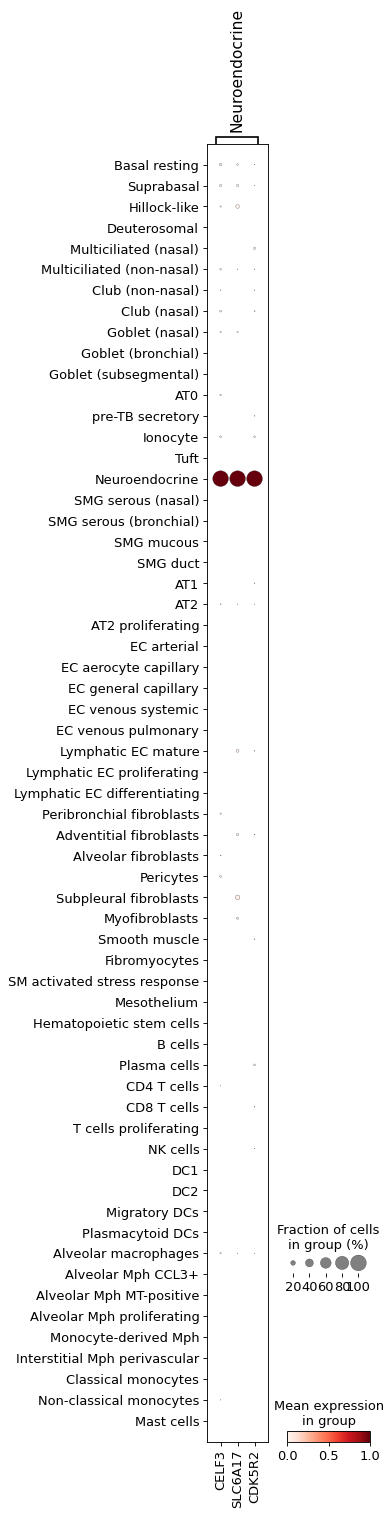

In [41]:
sc.pl.dotplot(
    pb_adatas[pb_name],
    var_names=markers_versus_atlas,
    groupby=pb_var_2,
    standard_scale="var",
)

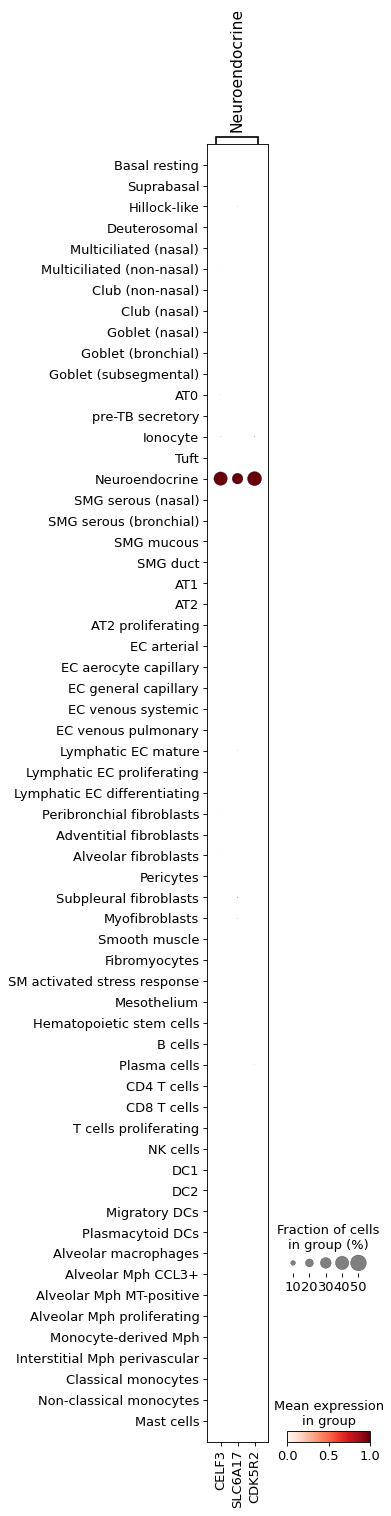

In [42]:
sc.pl.dotplot(
    adata,
    var_names=markers_versus_atlas,
    groupby=pb_var_2,
    standard_scale="var",
)

## Round 2: look for markers for 4 compartments, and ct markers that work within compartment:

add leveled annotations (lev1 - lev5 (lev1 is compartments)) to adata objects:

In [43]:
for lev in range(1, 6):
    manann_to_annlev = {
        manann: levann
        for manann, levann in zip(ct_reference.index, ct_reference[f"Level_{lev}"])
    }
    pb_adatas[pb_name].obs[f"ann_level_{lev}"] = pb_adatas[pb_name].obs.manual_ann.map(
        manann_to_annlev
    )
    pb_fraction_positive_adatas[pb_name].obs[
        f"ann_level_{lev}"
    ] = pb_fraction_positive_adatas[pb_name].obs.manual_ann.map(manann_to_annlev)

In [44]:
sc.tl.rank_genes_groups(
    pb_adatas[pb_name],
    groupby="ann_level_1",
    use_raw=False,
    key_added="ann_level_1_full_atlas",
)

... storing 'ann_level_1' as categorical
... storing 'ann_level_2' as categorical
... storing 'ann_level_3' as categorical
... storing 'ann_level_4' as categorical


In [45]:
sc.tl.filter_rank_genes_groups(
    pb_adatas[pb_name],
    use_raw=False,
    key="ann_level_1_full_atlas",
    key_added="ann_level_1_full_atlas_filtered",
    max_out_group_fraction=1,  # this will be constrained in the next step
    min_in_group_fraction=0.80,  # at least this fraction of sampls should express the gene in the cell type
)

In [46]:
markers_comps, comps_without_markers = marker_selection.get_unique_markers(
    adata=pb_adatas[pb_name],
    adata_expr_boolean=pb_fraction_positive_adatas[pb_name],
    ct_key="ann_level_1",
    rank_genes_groups_key="ann_level_1_full_atlas_filtered",
    max_out_ct_fraction=0.6,  # this is at pseudobulk level
    min_n_markers_per_ct=2,
    max_n_markers_per_ct=3,
    min_in_mean_pos_cell_fraction=0.5,  # this is at cell level (mean across samples)
)

Epithelial: Found sufficient markers!
Endothelial: Found sufficient markers!
Stroma: Found sufficient markers!
Immune: Found sufficient markers!


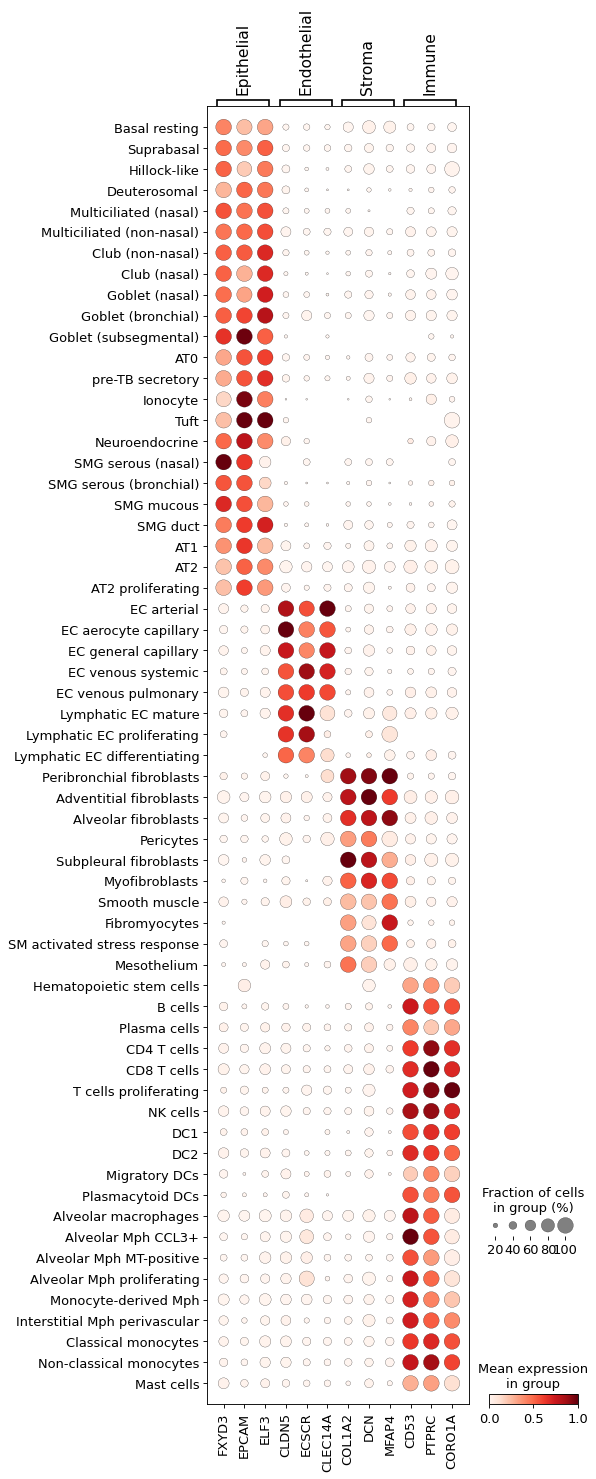

In [47]:
sc.pl.dotplot(
    pb_adatas[pb_name],
    var_names=markers_comps,
    groupby=pb_var_2,
    standard_scale="var",
)

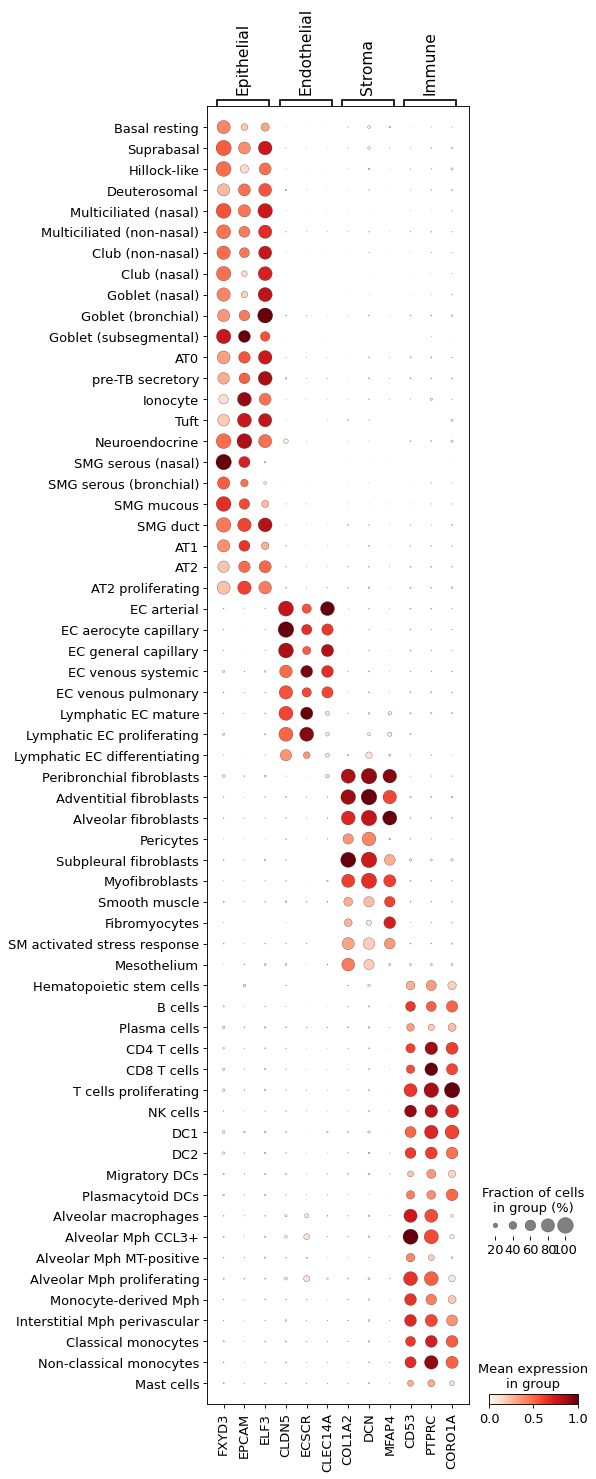

In [48]:
sc.pl.dotplot(
    adata,
    var_names=markers_comps,
    groupby=pb_var_2,
    standard_scale="var",
)

### Reference split 1: compartment (ann_level_1)

Split by compartment:

In [49]:
comps = sorted(adata.obs.ann_level_1.unique())

In [50]:
adatas_per_comp = dict()
adatas_frac_pos_per_comp = dict()
adatas_cellular_per_comp = dict()

In [51]:
for comp in comps:
    # pseudobulks
    adatas_per_comp[comp] = pb_adatas[pb_name][
        pb_adatas[pb_name].obs.ann_level_1 == comp, :
    ].copy()
    adatas_per_comp[comp].obs[pb_var_2].cat.remove_unused_categories()
    # fraction of positive cells pseudobulks
    adatas_frac_pos_per_comp[comp] = pb_fraction_positive_adatas[pb_name][
        pb_fraction_positive_adatas[pb_name].obs.ann_level_1 == comp, :
    ].copy()
    adatas_frac_pos_per_comp[comp].obs[pb_var_2].cat.remove_unused_categories()
    # original cell-level:
    adatas_cellular_per_comp[comp] = adata[adata.obs.ann_level_1 == comp, :].copy()
    adatas_cellular_per_comp[comp].obs[pb_var_2].cat.remove_unused_categories()

#### Check which cell types have unique markers in full compartment; add these to final marker dataframe:

In [52]:
ct_vs_comp_markers = dict()
cts_vs_comp_no_markers = list()
for comp in comps:
    sc.tl.rank_genes_groups(
        adatas_per_comp[comp],
        groupby=pb_var_2,
        use_raw=False,
        key_added=f"{pb_var_2}_vs_compartment",
    )
    sc.tl.filter_rank_genes_groups(
        adatas_per_comp[comp],
        use_raw=False,
        key=f"{pb_var_2}_vs_compartment",
        key_added=f"{pb_var_2}_vs_compartment_filtered",
        max_out_group_fraction=0.8,  # this will be constrained in the next step
        min_in_group_fraction=0.8,  # at least this fraction of sampls should express the gene in the cell type
    )
    comp_markers, comp_cts_no_markers = marker_selection.get_unique_markers(
        adata=adatas_per_comp[comp],
        adata_expr_boolean=adatas_frac_pos_per_comp[comp],
        ct_key=pb_var_2,
        rank_genes_groups_key=f"{pb_var_2}_vs_compartment_filtered",
        min_n_markers_per_ct=1,
        max_n_markers_per_ct=3,
        max_out_ct_fraction=0.7,
        min_in_mean_pos_cell_fraction=0.5,  # was 0.3
    )
    ct_vs_comp_markers[comp] = comp_markers
    cts_vs_comp_no_markers += comp_cts_no_markers

EC arterial: Found sufficient markers!
EC aerocyte capillary: Found sufficient markers!
EC general capillary: Not sufficient markers fulfilled criteria.
EC venous systemic: Not sufficient markers fulfilled criteria.
EC venous pulmonary: Not sufficient markers fulfilled criteria.
Lymphatic EC mature: Not sufficient markers fulfilled criteria.
Lymphatic EC proliferating: Found sufficient markers!


Lymphatic EC differentiating: Not sufficient markers fulfilled criteria.
Basal resting: Not sufficient markers fulfilled criteria.
Suprabasal: Not sufficient markers fulfilled criteria.
Hillock-like: Not sufficient markers fulfilled criteria.
Deuterosomal: Not sufficient markers fulfilled criteria.
Multiciliated (nasal): Not sufficient markers fulfilled criteria.
Multiciliated (non-nasal): Not sufficient markers fulfilled criteria.
Club (non-nasal): Not sufficient markers fulfilled criteria.
Club (nasal): Not sufficient markers fulfilled criteria.
Goblet (nasal): Not sufficient markers fulfilled criteria.
Goblet (bronchial): Not sufficient markers fulfilled criteria.
Goblet (subsegmental): Not sufficient markers fulfilled criteria.
AT0: Not sufficient markers fulfilled criteria.
pre-TB secretory: Not sufficient markers fulfilled criteria.
Ionocyte: Found sufficient markers!
Tuft: Found sufficient markers!
Neuroendocrine: Found sufficient markers!
SMG serous (nasal): Not sufficient mark

AT2 proliferating: Not sufficient markers fulfilled criteria.
Hematopoietic stem cells: Found sufficient markers!
B cells: Found sufficient markers!
Plasma cells: Found sufficient markers!
CD4 T cells: Not sufficient markers fulfilled criteria.
CD8 T cells: Not sufficient markers fulfilled criteria.
T cells proliferating: Not sufficient markers fulfilled criteria.
NK cells: Not sufficient markers fulfilled criteria.
DC1: Found sufficient markers!
DC2: Not sufficient markers fulfilled criteria.
Migratory DCs: Found sufficient markers!
Plasmacytoid DCs: Found sufficient markers!
Alveolar macrophages: Not sufficient markers fulfilled criteria.
Alveolar Mph CCL3+: Not sufficient markers fulfilled criteria.
Alveolar Mph MT-positive: Not sufficient markers fulfilled criteria.
Alveolar Mph proliferating: Not sufficient markers fulfilled criteria.
Monocyte-derived Mph: Not sufficient markers fulfilled criteria.
Interstitial Mph perivascular: Not sufficient markers fulfilled criteria.
Classical

Non-classical monocytes: Not sufficient markers fulfilled criteria.
Mast cells: Found sufficient markers!
Peribronchial fibroblasts: Not sufficient markers fulfilled criteria.
Adventitial fibroblasts: Not sufficient markers fulfilled criteria.
Alveolar fibroblasts: Not sufficient markers fulfilled criteria.
Pericytes: Found sufficient markers!
Subpleural fibroblasts: Not sufficient markers fulfilled criteria.
Myofibroblasts: Not sufficient markers fulfilled criteria.
Smooth muscle: Not sufficient markers fulfilled criteria.
Fibromyocytes: Found sufficient markers!
SM activated stress response: Not sufficient markers fulfilled criteria.
Mesothelium: Found sufficient markers!


plot suggested markers to see if they make sense:

Endothelial, pseudobulks:


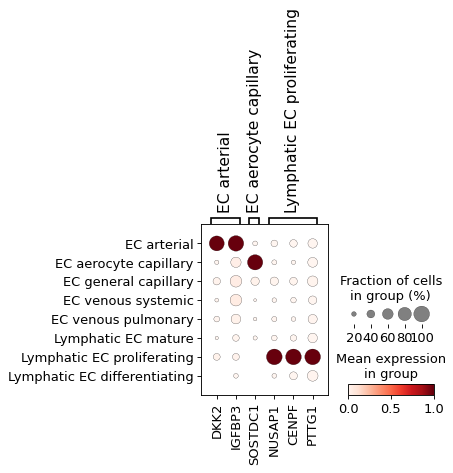

Endothelial, cells:


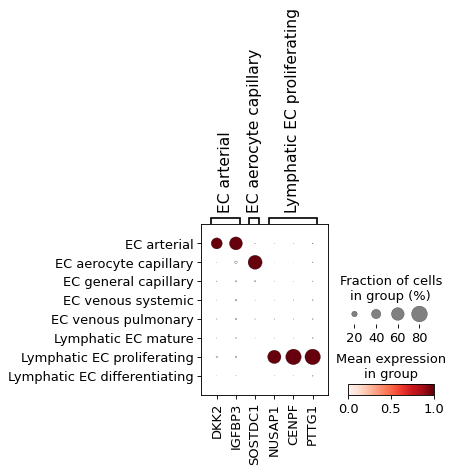

Epithelial, pseudobulks:


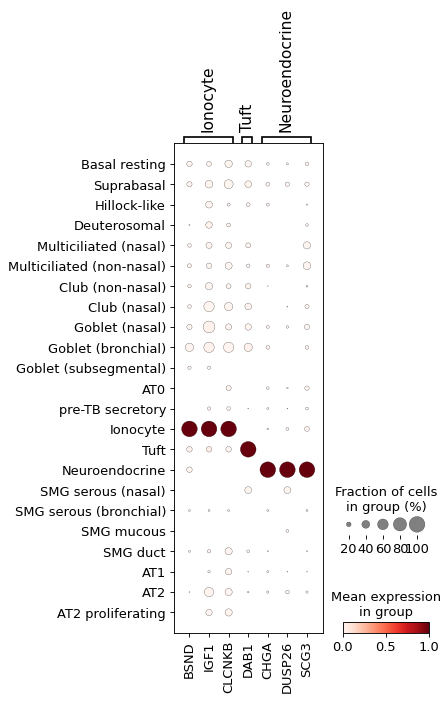

Epithelial, cells:


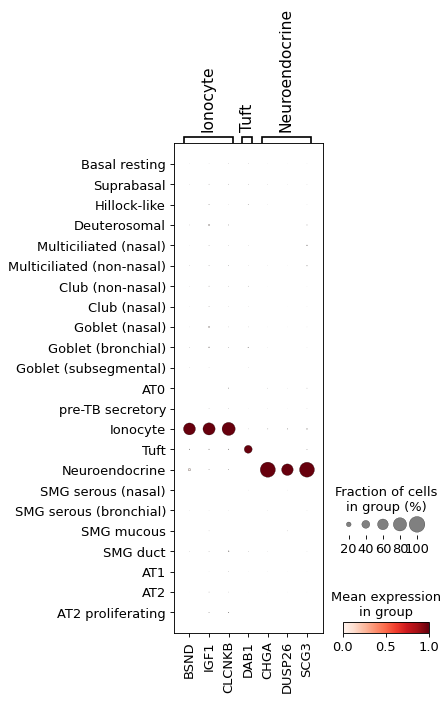

Immune, pseudobulks:


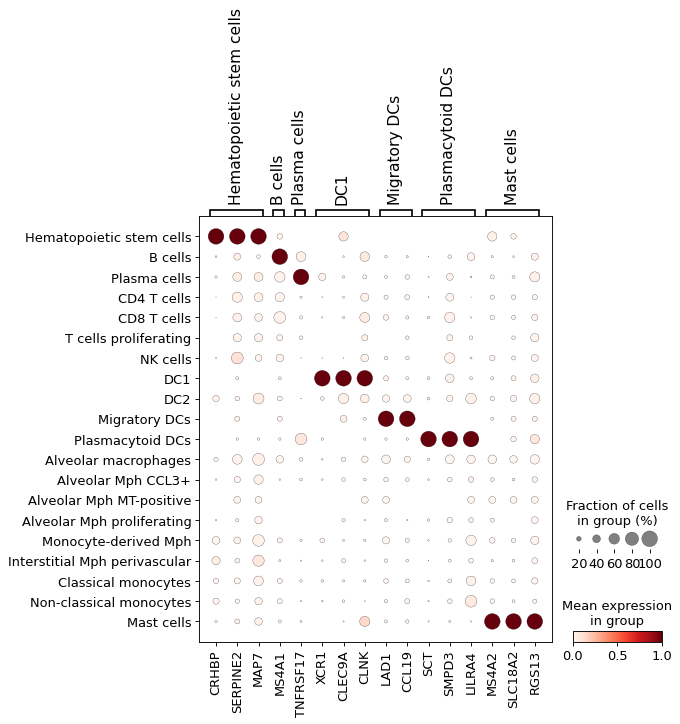

Immune, cells:


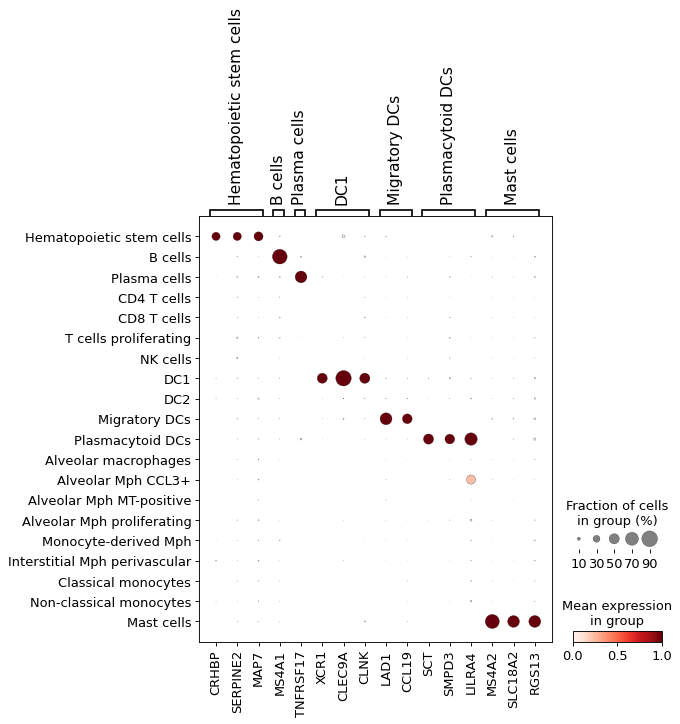

Stroma, pseudobulks:


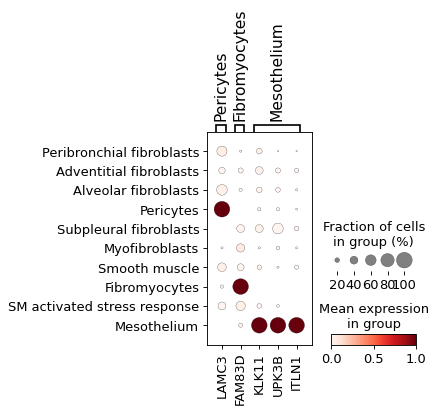

Stroma, cells:


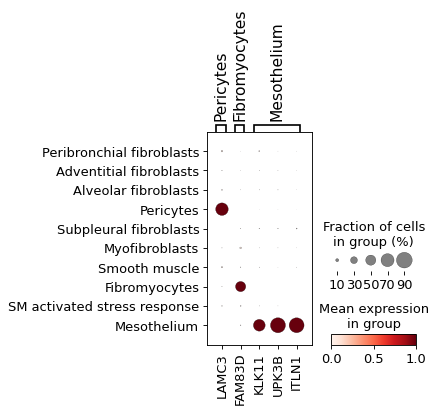

In [53]:
for comp in comps:
    marker_dict = ct_vs_comp_markers[comp]
    # keep only markers for cts for which we still need markers
    print(f"{comp}, pseudobulks:")
    sc.pl.dotplot(
        adatas_per_comp[comp],
        var_names=marker_dict,
        groupby=pb_var_2,
        standard_scale="var",
    )
    print(f"{comp}, cells:")
    sc.pl.dotplot(
        adatas_cellular_per_comp[comp],
        var_names=marker_dict,
        groupby=pb_var_2,
        standard_scale="var",
    )

In [54]:
ct_vs_comp_markers

{'Endothelial': {'EC arterial': ['DKK2', 'IGFBP3'],
  'EC aerocyte capillary': ['SOSTDC1'],
  'Lymphatic EC proliferating': ['NUSAP1', 'CENPF', 'PTTG1']},
 'Epithelial': {'Ionocyte': ['BSND', 'IGF1', 'CLCNKB'],
  'Tuft': ['DAB1'],
  'Neuroendocrine': ['CHGA', 'DUSP26', 'SCG3']},
 'Immune': {'Hematopoietic stem cells': ['CRHBP', 'SERPINE2', 'MAP7'],
  'B cells': ['MS4A1'],
  'Plasma cells': ['TNFRSF17'],
  'DC1': ['XCR1', 'CLEC9A', 'CLNK'],
  'Migratory DCs': ['LAD1', 'CCL19'],
  'Plasmacytoid DCs': ['SCT', 'SMPD3', 'LILRA4'],
  'Mast cells': ['MS4A2', 'SLC18A2', 'RGS13']},
 'Stroma': {'Pericytes': ['LAMC3'],
  'Fibromyocytes': ['FAM83D'],
  'Mesothelium': ['KLK11', 'UPK3B', 'ITLN1']}}

Store markers where successfully found (and for cell types for which we didn't have markers yet):

In [55]:
for comp, comp_marker_dict in ct_vs_comp_markers.items():
    comp_markers = markers_comps[comp]
    n_comp_markers = len(comp_markers)
    for ct, ct_markers in comp_marker_dict.items():
        if ct in cts_without_markers_1:
            n_ct_markers = len(ct_markers)
            marker_df_final[f"{ct}_marker"][:n_comp_markers] = comp_markers
            marker_df_final[f"{ct}_marker_for"][:n_comp_markers] = comp
            marker_df_final[f"{ct}_marker_reference"][:n_comp_markers] = "Full atlas"
            marker_df_final[f"{ct}_marker"][
                n_comp_markers : (n_comp_markers + n_ct_markers)
            ] = ct_markers
            marker_df_final[f"{ct}_marker_for"][
                n_comp_markers : (n_comp_markers + n_ct_markers)
            ] = ct
            marker_df_final[f"{ct}_marker_reference"][
                n_comp_markers : (n_comp_markers + n_ct_markers)
            ] = comp

update cts without final marker set:

In [56]:
cts_without_markers_2 = list(set(cts_without_markers_1) & set(cts_vs_comp_no_markers))

In [57]:
len(cts_without_markers_2)

45

## Round 3; Second split (ann_level_2): look for markers unique within ann_level_2 group of cell types:

#### first get markers for "reference" (i.e. ann_level_2 cell groups)

Get markers for split (ann_level_2 versus ann_level_1)

In [58]:
annlev2_markers_per_comp = dict()
annlev2_cts_no_markers = list()

In [59]:
lev = 2
for comp in comps:
    sc.tl.rank_genes_groups(
        adatas_per_comp[comp],
        groupby=f"ann_level_{lev}",
        use_raw=False,
        key_added=f"annlev{lev}_vs_compartment",
    )
    sc.tl.filter_rank_genes_groups(
        adatas_per_comp[comp],
        use_raw=False,
        key=f"annlev{lev}_vs_compartment",
        key_added=f"annlev{lev}_vs_compartment_filtered",
        max_out_group_fraction=0.9,  # this will be constrained in the next step
        min_in_group_fraction=0.8,  # at least this fraction of sampls should express the gene in the cell type
    )
    comp_markers, comp_cts_no_markers = marker_selection.get_unique_markers(
        adata=adatas_per_comp[comp],
        adata_expr_boolean=adatas_frac_pos_per_comp[comp],
        ct_key=f"ann_level_{lev}",
        rank_genes_groups_key=f"annlev{lev}_vs_compartment_filtered",
        min_n_markers_per_ct=1,  # 2,
        max_n_markers_per_ct=3,
        max_out_ct_fraction=0.99,  # 0.99,  # this is pseudobulk level
        min_in_mean_pos_cell_fraction=0.50,  # this is cell level, mean over samples
    )
    annlev2_markers_per_comp[comp] = comp_markers
    annlev2_cts_no_markers.append(comp_cts_no_markers)

Blood vessels: Found sufficient markers!
Lymphatic EC: Found sufficient markers!


Airway epithelium: Found sufficient markers!
Submucosal Gland: Found sufficient markers!
Alveolar epithelium: Found sufficient markers!
Hematopoietic stem cells: Found sufficient markers!


Lymphoid: Found sufficient markers!
Myeloid: Found sufficient markers!
Fibroblast lineage: Found sufficient markers!
Smooth muscle: Found sufficient markers!
Mesothelium: Found sufficient markers!


Endothelial, pseudobulks:


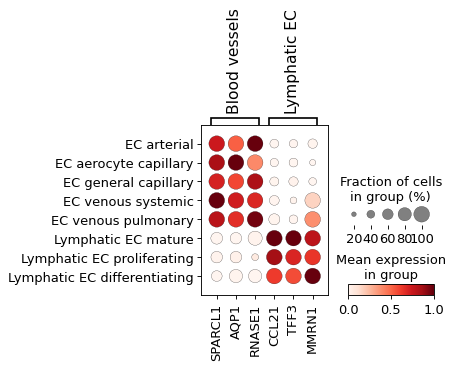

Endothelial, cell-level:


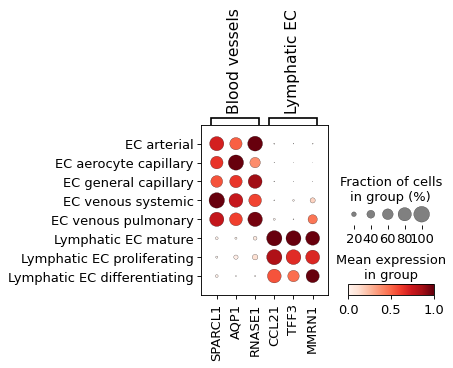

Epithelial, pseudobulks:


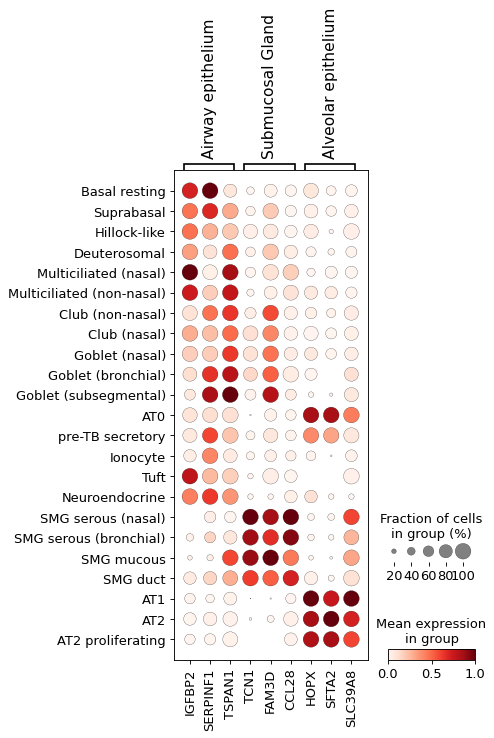

Epithelial, cell-level:


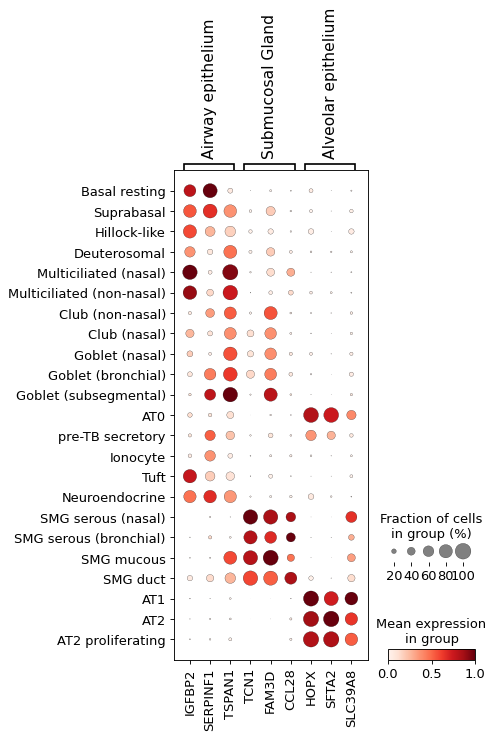

Immune, pseudobulks:


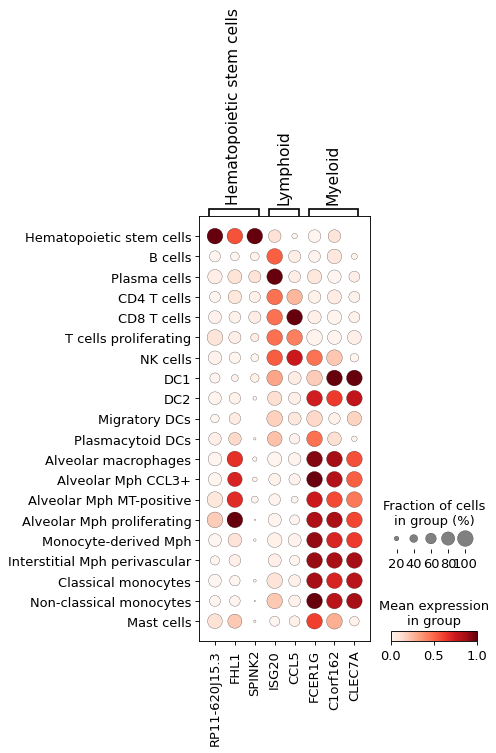

Immune, cell-level:


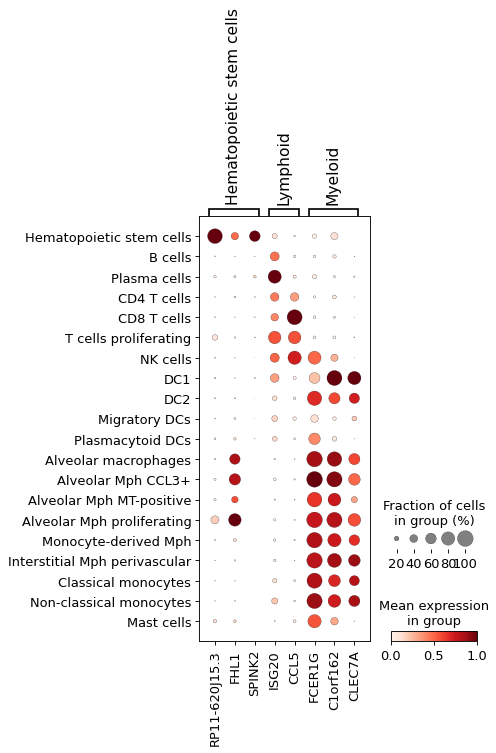

Stroma, pseudobulks:


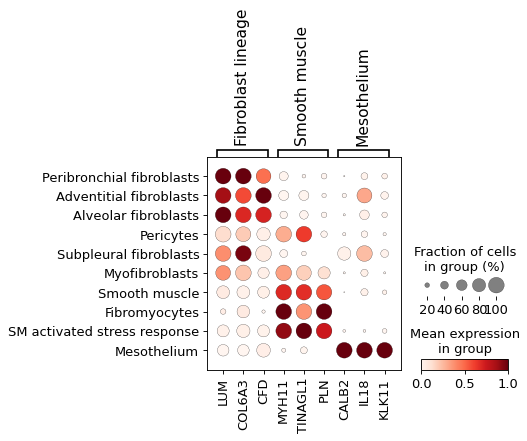

Stroma, cell-level:


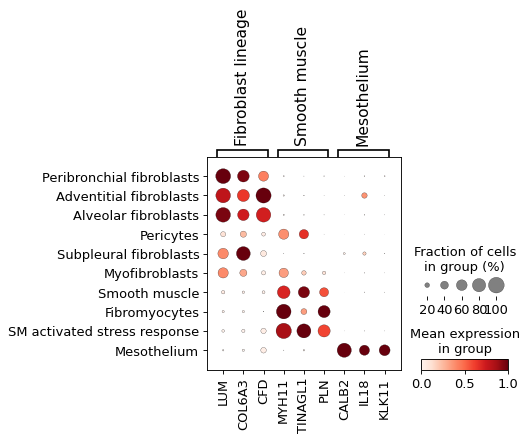

In [60]:
for comp in comps:
    print(f"{comp}, pseudobulks:")
    sc.pl.dotplot(
        adatas_per_comp[comp],
        var_names=annlev2_markers_per_comp[comp],
        groupby=pb_var_2,
        standard_scale="var",
    )
    print(f"{comp}, cell-level:")
    sc.pl.dotplot(
        adatas_cellular_per_comp[comp],
        var_names=annlev2_markers_per_comp[comp],
        groupby=pb_var_2,
        standard_scale="var",
    )

check if any of these are part of the final manual anntoations, and if we already had markers for them (then we can kick them out of the marker checks):

In [61]:
lev2_anns = adata.obs.ann_level_2.unique()

In [62]:
lev2_finest_anns_that_had_markers_already = [
    ann
    for ann in lev2_anns
    if ann in ct_reference.index and ann not in cts_without_markers_2
]
lev2_anns_without_markers = [
    ann for ann in lev2_anns if ann not in lev2_finest_anns_that_had_markers_already
]

Now split adata by ann_level_2:

In [63]:
adatas_per_lev2ann = dict()
adatas_frac_pos_per_lev2ann = dict()
adatas_cellular_per_lev2ann = dict()

In [64]:
for lev2ann in lev2_anns_without_markers:
    # pseudobulks
    adatas_per_lev2ann[lev2ann] = pb_adatas[pb_name][
        pb_adatas[pb_name].obs.ann_level_2 == lev2ann, :
    ].copy()
    adatas_per_lev2ann[lev2ann].obs[pb_var_2].cat.remove_unused_categories()
    # fraction positive pseudobulks
    adatas_frac_pos_per_lev2ann[lev2ann] = pb_fraction_positive_adatas[pb_name][
        pb_fraction_positive_adatas[pb_name].obs.ann_level_2 == lev2ann, :
    ].copy()
    adatas_frac_pos_per_lev2ann[lev2ann].obs[pb_var_2].cat.remove_unused_categories()
    # cellular (original) adata:
    adatas_cellular_per_lev2ann[lev2ann] = adata[
        adata.obs.ann_level_2 == lev2ann, :
    ].copy()
    adatas_cellular_per_lev2ann[lev2ann].obs[pb_var_2].cat.remove_unused_categories()

#### Check which cell types have unique markers within their level 2 ann group:

In [65]:
ct_vs_lev2_markers = dict()
cts_vs_lev2_no_markers = list()
for lev2ann in lev2_anns_without_markers:
    sc.tl.rank_genes_groups(
        adatas_per_lev2ann[lev2ann],
        groupby=pb_var_2,
        use_raw=False,
        key_added=f"{pb_var_2}_vs_lev2ann",
    )
    sc.tl.filter_rank_genes_groups(
        adatas_per_lev2ann[lev2ann],
        use_raw=False,
        key=f"{pb_var_2}_vs_lev2ann",
        key_added=f"{pb_var_2}_vs_lev2ann_filtered",
        max_out_group_fraction=0.9,  # this will be constrained in the next step
        min_in_group_fraction=0.8,  # at least this fraction of sampls should express the gene in the cell type
    )
    lev2_markers, lev2_cts_no_markers = marker_selection.get_unique_markers(
        adata=adatas_per_lev2ann[lev2ann],
        adata_expr_boolean=adatas_frac_pos_per_lev2ann[lev2ann],
        ct_key=pb_var_2,
        rank_genes_groups_key=f"{pb_var_2}_vs_lev2ann_filtered",
        min_n_markers_per_ct=2,
        max_n_markers_per_ct=3,
        max_out_ct_fraction=0.99,  # this is pseudobulk level
        min_in_mean_pos_cell_fraction=0.50,  # this is cell level, mean over samples
    )
    ct_vs_lev2_markers[lev2ann] = lev2_markers
    cts_vs_lev2_no_markers += lev2_cts_no_markers

DC1: Found sufficient markers!
DC2: Not sufficient markers fulfilled criteria.
Migratory DCs: Found sufficient markers!
Plasmacytoid DCs: Found sufficient markers!
Alveolar macrophages: Not sufficient markers fulfilled criteria.
Alveolar Mph CCL3+: Found sufficient markers!
Alveolar Mph MT-positive: Not sufficient markers fulfilled criteria.
Alveolar Mph proliferating: Found sufficient markers!
Monocyte-derived Mph: Not sufficient markers fulfilled criteria.
Interstitial Mph perivascular: Found sufficient markers!
Classical monocytes: Not sufficient markers fulfilled criteria.


Non-classical monocytes: Not sufficient markers fulfilled criteria.
Mast cells: Found sufficient markers!
B cells: Found sufficient markers!
Plasma cells: Found sufficient markers!
CD4 T cells: Not sufficient markers fulfilled criteria.


CD8 T cells: Not sufficient markers fulfilled criteria.
T cells proliferating: Found sufficient markers!
NK cells: Found sufficient markers!
AT1: Found sufficient markers!


AT2: Found sufficient markers!
AT2 proliferating: Found sufficient markers!
Basal resting: Not sufficient markers fulfilled criteria.
Suprabasal: Not sufficient markers fulfilled criteria.
Hillock-like: Found sufficient markers!
Deuterosomal: Found sufficient markers!
Multiciliated (nasal): Found sufficient markers!
Multiciliated (non-nasal): Not sufficient markers fulfilled criteria.
Club (non-nasal): Not sufficient markers fulfilled criteria.
Club (nasal): Not sufficient markers fulfilled criteria.
Goblet (nasal): Not sufficient markers fulfilled criteria.
Goblet (bronchial): Found sufficient markers!
Goblet (subsegmental): Not sufficient markers fulfilled criteria.
AT0: Found sufficient markers!
pre-TB secretory: Not sufficient markers fulfilled criteria.
Ionocyte: Found sufficient markers!


Tuft: Found sufficient markers!
Neuroendocrine: Found sufficient markers!
EC arterial: Found sufficient markers!
EC aerocyte capillary: Found sufficient markers!
EC general capillary: Found sufficient markers!


EC venous systemic: Not sufficient markers fulfilled criteria.
EC venous pulmonary: Found sufficient markers!
Peribronchial fibroblasts: Not sufficient markers fulfilled criteria.
Adventitial fibroblasts: Found sufficient markers!
Alveolar fibroblasts: Not sufficient markers fulfilled criteria.
Pericytes: Found sufficient markers!
Subpleural fibroblasts: Found sufficient markers!


Myofibroblasts: Not sufficient markers fulfilled criteria.
Smooth muscle: Not sufficient markers fulfilled criteria.


Fibromyocytes: Found sufficient markers!
SM activated stress response: Found sufficient markers!
SMG serous (nasal): Found sufficient markers!


SMG serous (bronchial): Not sufficient markers fulfilled criteria.
SMG mucous: Found sufficient markers!
SMG duct: Found sufficient markers!
Lymphatic EC mature: Not sufficient markers fulfilled criteria.
Lymphatic EC proliferating: Found sufficient markers!
Lymphatic EC differentiating: Not sufficient markers fulfilled criteria.


In [66]:
sorted(set(cts_vs_lev2_no_markers) & set(cts_without_markers_2))

['Alveolar Mph MT-positive',
 'Alveolar fibroblasts',
 'Alveolar macrophages',
 'Basal resting',
 'CD4 T cells',
 'CD8 T cells',
 'Classical monocytes',
 'Club (nasal)',
 'Club (non-nasal)',
 'DC2',
 'EC venous systemic',
 'Goblet (nasal)',
 'Goblet (subsegmental)',
 'Lymphatic EC differentiating',
 'Lymphatic EC mature',
 'Monocyte-derived Mph',
 'Multiciliated (non-nasal)',
 'Myofibroblasts',
 'Non-classical monocytes',
 'Peribronchial fibroblasts',
 'SMG serous (bronchial)',
 'Smooth muscle',
 'Suprabasal',
 'pre-TB secretory']

In [67]:
len(sorted(set(cts_vs_lev2_no_markers) & set(cts_without_markers_2)))

24

MYELOID pseudobulk:


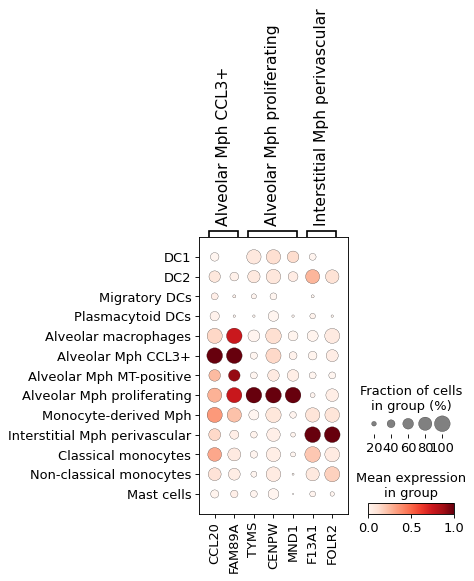

MYELOID cell-level:


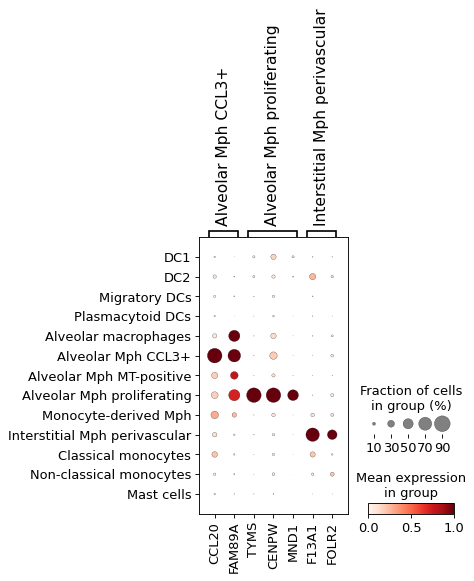

LYMPHOID pseudobulk:


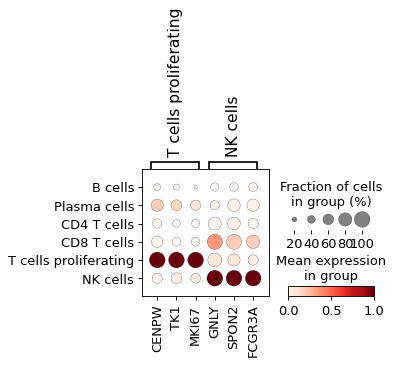

LYMPHOID cell-level:


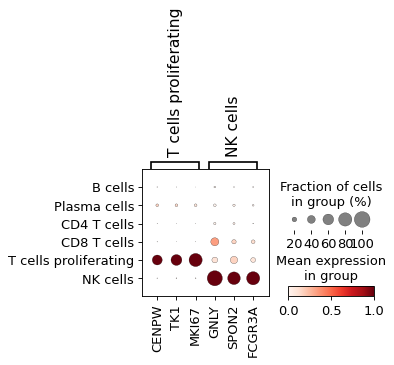

ALVEOLAR EPITHELIUM pseudobulk:


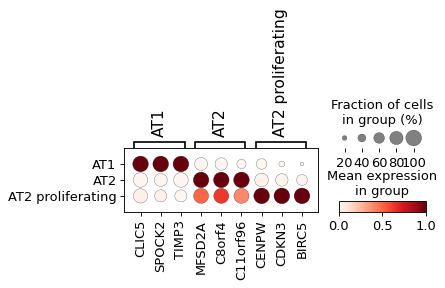

ALVEOLAR EPITHELIUM cell-level:


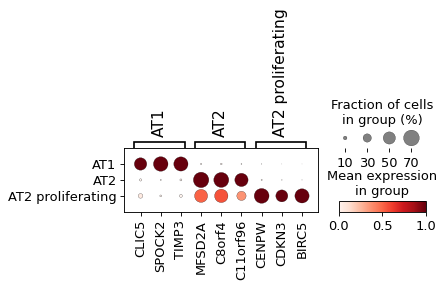

AIRWAY EPITHELIUM pseudobulk:


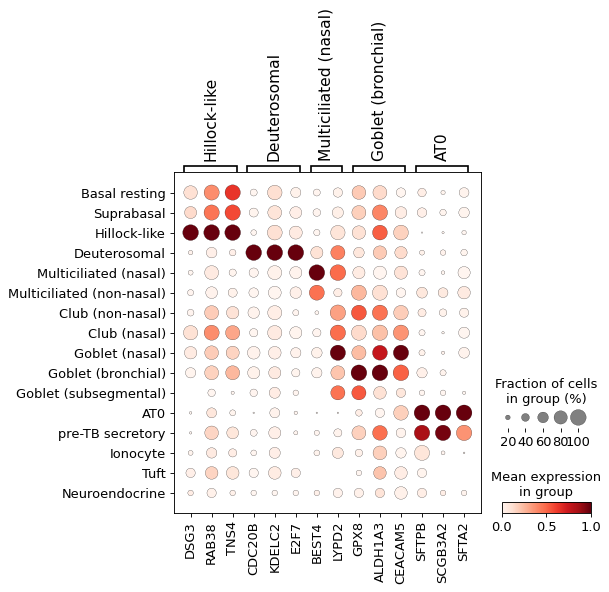

AIRWAY EPITHELIUM cell-level:


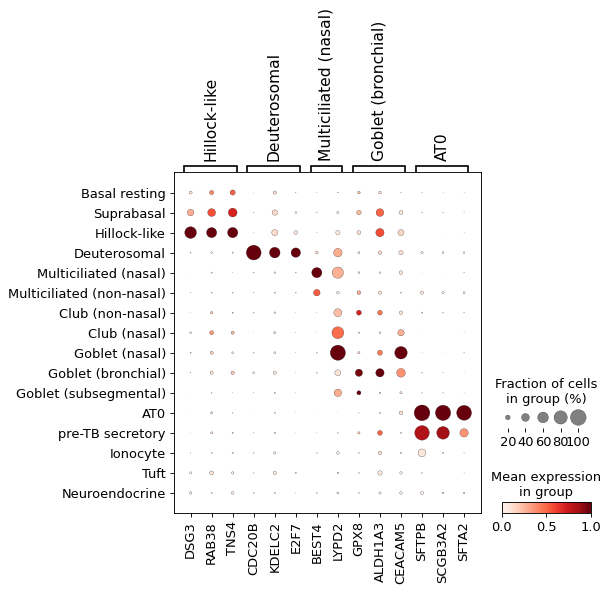

BLOOD VESSELS pseudobulk:


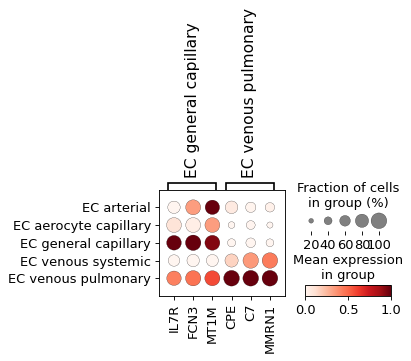

BLOOD VESSELS cell-level:


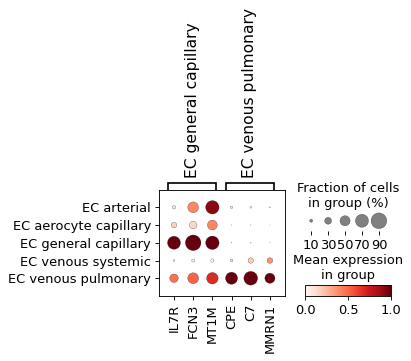

FIBROBLAST LINEAGE pseudobulk:


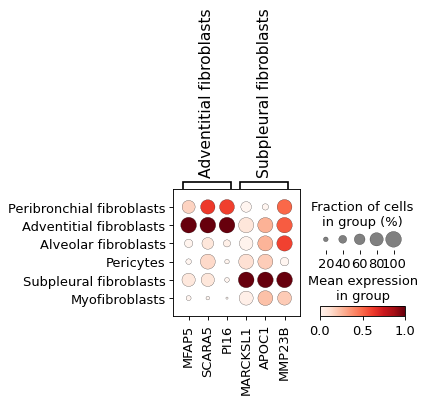

FIBROBLAST LINEAGE cell-level:


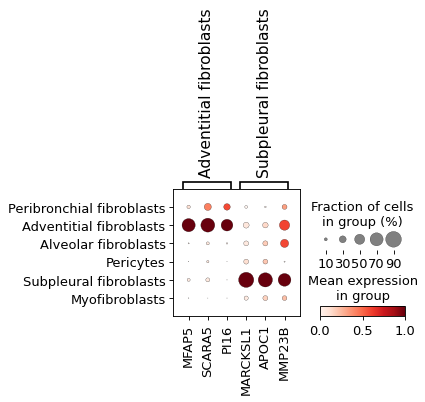

SMOOTH MUSCLE pseudobulk:


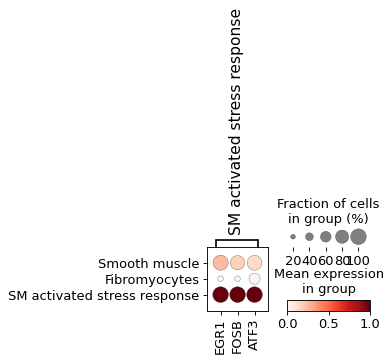

SMOOTH MUSCLE cell-level:


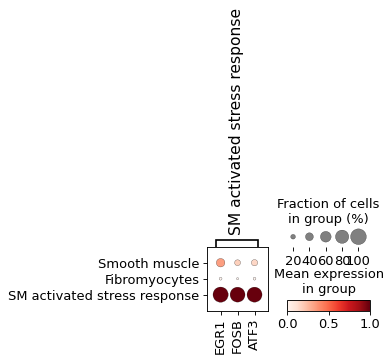

SUBMUCOSAL GLAND pseudobulk:


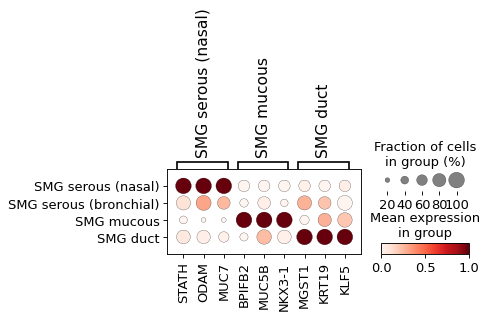

SUBMUCOSAL GLAND cell-level:


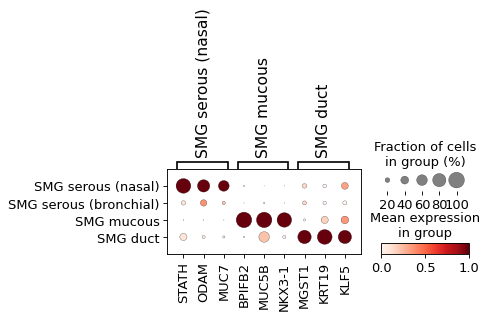

No new markers found/needed for Lymphatic EC cell types.


In [68]:
for lev2ann in lev2_anns_without_markers:
    cts_to_keep = [
        ct
        for ct in adatas_per_lev2ann[lev2ann].obs[pb_var_2].unique()
        if ct in cts_without_markers_2
    ]
    if len(cts_to_keep) > 0:
        # keep only markers for cts for which we still need markers
        marker_dict = {
            ct: ct_markers
            for ct, ct_markers in zip(
                ct_vs_lev2_markers[lev2ann].keys(), ct_vs_lev2_markers[lev2ann].values()
            )
            if ct in cts_to_keep
        }
        if len(marker_dict) > 0:
            print(lev2ann.upper(), "pseudobulk:")
            sc.pl.dotplot(
                adatas_per_lev2ann[lev2ann],
                var_names=marker_dict,
                groupby=pb_var_2,
                standard_scale="var",
            )
            print(lev2ann.upper(), "cell-level:")
            sc.pl.dotplot(
                adatas_cellular_per_lev2ann[lev2ann],
                var_names=marker_dict,
                groupby=pb_var_2,
                standard_scale="var",
            )
        else:
            print(f"No new markers found/needed for {lev2ann} cell types.")
    else:
        print(f"No new markers found for {lev2ann} cell types.")

Store markers for cell types where we successfully detected markers:

In [69]:
lev2_to_comp = adata.obs.groupby("ann_level_2").agg({"ann_level_1": "first"})
lev2_to_comp = {
    lev2: lev1 for lev2, lev1 in zip(lev2_to_comp.index, lev2_to_comp.ann_level_1)
}

In [70]:
for lev2ann, lev2_marker_dict in ct_vs_lev2_markers.items():
    # get markers for compartment (=ann_level_1) from which lev2 came:
    comp = lev2_to_comp[lev2ann]
    comp_markers = markers_comps[comp]
    n_comp_markers = len(comp_markers)
    # get markers for lev2 annotation (i.e. not for final annotation but reference)
    lev2_markers = annlev2_markers_per_comp[comp][lev2ann]
    n_lev2_markers = len(lev2_markers)
    # now loop through cts within the lev2 compartment
    for ct, ct_markers in lev2_marker_dict.items():
        if ct in cts_without_markers_2:
            n_ct_markers = len(ct_markers)
            # compartment markers
            marker_df_final[f"{ct}_marker"][:n_comp_markers] = comp_markers
            marker_df_final[f"{ct}_marker_for"][:n_comp_markers] = comp
            marker_df_final[f"{ct}_marker_reference"][:n_comp_markers] = "Full atlas"
            # ann level 2 markers
            marker_df_final[f"{ct}_marker"][
                n_comp_markers : (n_comp_markers + n_lev2_markers)
            ] = lev2_markers
            marker_df_final[f"{ct}_marker_for"][
                n_comp_markers : (n_comp_markers + n_lev2_markers)
            ] = lev2ann
            marker_df_final[f"{ct}_marker_reference"][
                n_comp_markers : (n_comp_markers + n_lev2_markers)
            ] = comp
            # ct markers
            marker_df_final[f"{ct}_marker"][
                (n_comp_markers + n_lev2_markers) : (
                    n_comp_markers + n_lev2_markers + n_ct_markers
                )
            ] = ct_markers
            marker_df_final[f"{ct}_marker_for"][
                (n_comp_markers + n_lev2_markers) : (
                    n_comp_markers + n_lev2_markers + n_ct_markers
                )
            ] = ct
            marker_df_final[f"{ct}_marker_reference"][
                (n_comp_markers + n_lev2_markers) : (
                    n_comp_markers + n_lev2_markers + n_ct_markers
                )
            ] = lev2ann

In [71]:
cts_without_markers_3 = set(cts_without_markers_2) & set(cts_vs_lev2_no_markers)

In [72]:
cts_without_markers_3

{'Alveolar Mph MT-positive',
 'Alveolar fibroblasts',
 'Alveolar macrophages',
 'Basal resting',
 'CD4 T cells',
 'CD8 T cells',
 'Classical monocytes',
 'Club (nasal)',
 'Club (non-nasal)',
 'DC2',
 'EC venous systemic',
 'Goblet (nasal)',
 'Goblet (subsegmental)',
 'Lymphatic EC differentiating',
 'Lymphatic EC mature',
 'Monocyte-derived Mph',
 'Multiciliated (non-nasal)',
 'Myofibroblasts',
 'Non-classical monocytes',
 'Peribronchial fibroblasts',
 'SMG serous (bronchial)',
 'Smooth muscle',
 'Suprabasal',
 'pre-TB secretory'}

## Round 4: split again by ann_level_2, but select markers with looser criteria for cell types still missing good markers:

In [73]:
ct_vs_lev2_markers_loose = dict()
cts_vs_lev2_no_markers_loose = list()
for lev2ann in lev2_anns_without_markers:
    sc.tl.rank_genes_groups(
        adatas_per_lev2ann[lev2ann],
        groupby=pb_var_2,
        use_raw=False,
        key_added=f"{pb_var_2}_vs_lev2ann_loose",
    )
    sc.tl.filter_rank_genes_groups(
        adatas_per_lev2ann[lev2ann],
        use_raw=False,
        key=f"{pb_var_2}_vs_lev2ann_loose",
        key_added=f"{pb_var_2}_vs_lev2ann_loose_filtered",
        max_out_group_fraction=0.85,  # this will be constrained in the next step
        min_in_group_fraction=0.85,  # at least this fraction of samples should express the gene in the cell type
        min_fold_change=2.5,
    )
    lev2_markers_loose, lev2_cts_no_markers_loose = marker_selection.get_unique_markers(
        adata=adatas_per_lev2ann[lev2ann],
        adata_expr_boolean=adatas_frac_pos_per_lev2ann[lev2ann],
        ct_key=pb_var_2,
        rank_genes_groups_key=f"{pb_var_2}_vs_lev2ann_loose_filtered",
        min_n_markers_per_ct=2,
        max_n_markers_per_ct=3,
        max_out_ct_fraction=1,  # this is pseudobulk level
        min_in_mean_pos_cell_fraction=0.25,  # this is cell level, mean over samples
    )
    ct_vs_lev2_markers_loose[lev2ann] = lev2_markers_loose
    cts_vs_lev2_no_markers_loose += lev2_cts_no_markers_loose

DC1: Found sufficient markers!
DC2: Found sufficient markers!
Migratory DCs: Found sufficient markers!
Plasmacytoid DCs: Found sufficient markers!
Alveolar macrophages: Found sufficient markers!
Alveolar Mph CCL3+: Found sufficient markers!
Alveolar Mph MT-positive: Found sufficient markers!
Alveolar Mph proliferating: Found sufficient markers!
Monocyte-derived Mph: Not sufficient markers fulfilled criteria.
Interstitial Mph perivascular: Found sufficient markers!
Classical monocytes: Found sufficient markers!
Non-classical monocytes: Found sufficient markers!


Mast cells: Found sufficient markers!
B cells: Found sufficient markers!
Plasma cells: Found sufficient markers!
CD4 T cells: Not sufficient markers fulfilled criteria.


CD8 T cells: Found sufficient markers!
T cells proliferating: Found sufficient markers!
NK cells: Found sufficient markers!


AT1: Found sufficient markers!
AT2: Found sufficient markers!
AT2 proliferating: Found sufficient markers!
Basal resting: Found sufficient markers!
Suprabasal: Found sufficient markers!
Hillock-like: Found sufficient markers!
Deuterosomal: Found sufficient markers!
Multiciliated (nasal): Found sufficient markers!
Multiciliated (non-nasal): Found sufficient markers!
Club (non-nasal): Found sufficient markers!
Club (nasal): Found sufficient markers!
Goblet (nasal): Found sufficient markers!
Goblet (bronchial): Found sufficient markers!
Goblet (subsegmental): Found sufficient markers!
AT0: Found sufficient markers!
pre-TB secretory: Found sufficient markers!
Ionocyte: Found sufficient markers!
Tuft: Found sufficient markers!


Neuroendocrine: Found sufficient markers!
EC arterial: Found sufficient markers!
EC aerocyte capillary: Found sufficient markers!
EC general capillary: Found sufficient markers!
EC venous systemic: Found sufficient markers!


EC venous pulmonary: Found sufficient markers!
Peribronchial fibroblasts: Found sufficient markers!
Adventitial fibroblasts: Found sufficient markers!
Alveolar fibroblasts: Found sufficient markers!
Pericytes: Found sufficient markers!


Subpleural fibroblasts: Found sufficient markers!
Myofibroblasts: Found sufficient markers!


Smooth muscle: Not sufficient markers fulfilled criteria.
Fibromyocytes: Found sufficient markers!
SM activated stress response: Found sufficient markers!


SMG serous (nasal): Found sufficient markers!
SMG serous (bronchial): Found sufficient markers!
SMG mucous: Found sufficient markers!
SMG duct: Found sufficient markers!
Lymphatic EC mature: Not sufficient markers fulfilled criteria.
Lymphatic EC proliferating: Found sufficient markers!
Lymphatic EC differentiating: Not sufficient markers fulfilled criteria.


MYELOID pseudobulk:


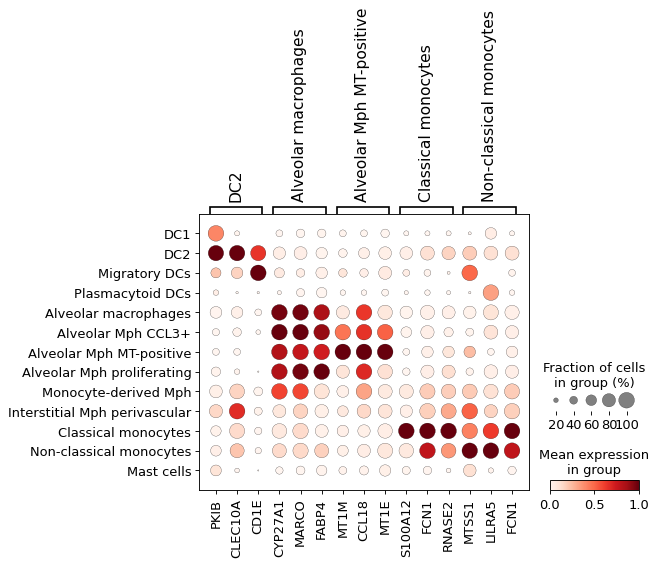

MYELOID cell-level:


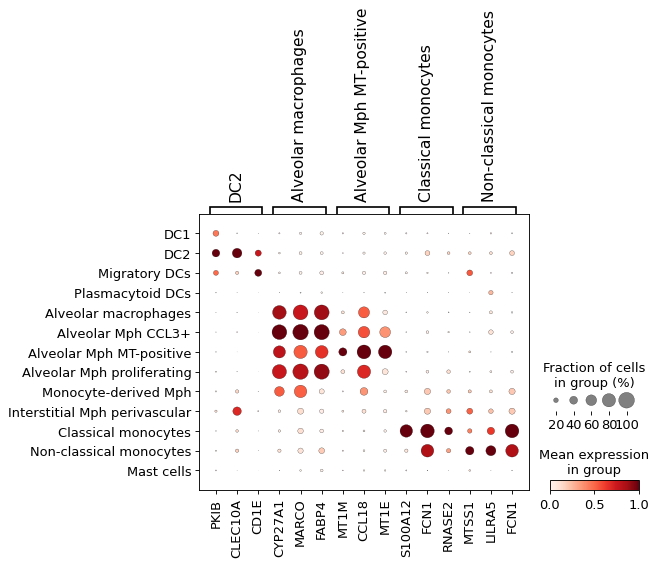

LYMPHOID pseudobulk:


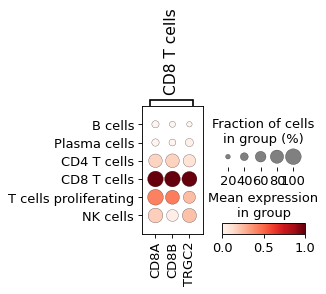

LYMPHOID cell-level:


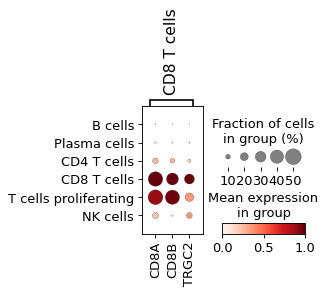

No new markers found for Alveolar epithelium cell types.
AIRWAY EPITHELIUM pseudobulk:


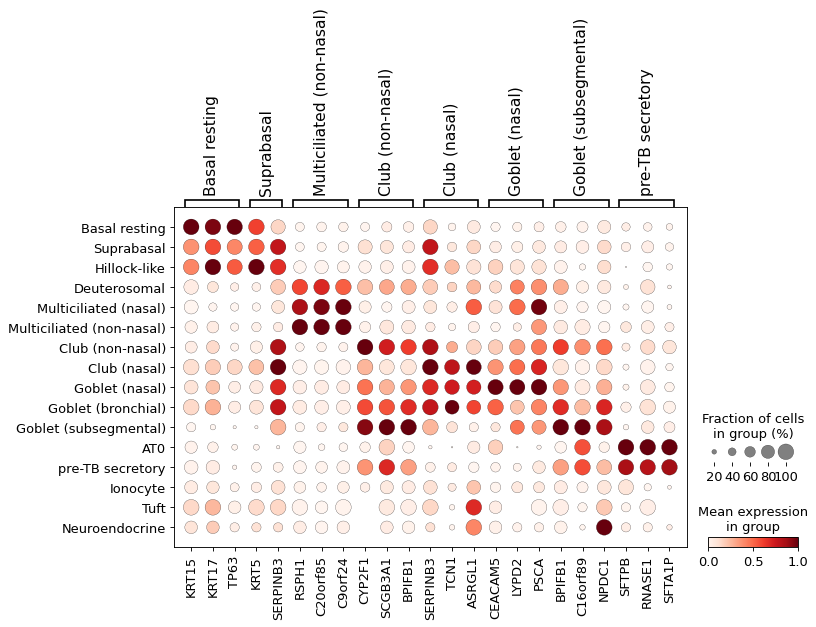

AIRWAY EPITHELIUM cell-level:


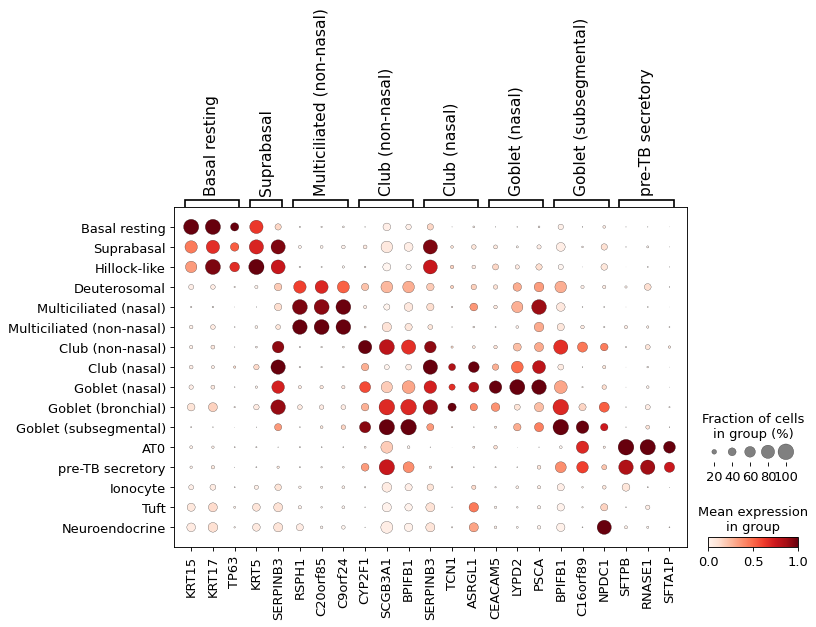

BLOOD VESSELS pseudobulk:


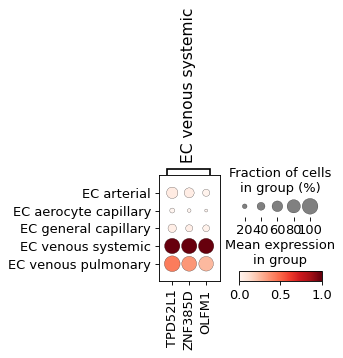

BLOOD VESSELS cell-level:


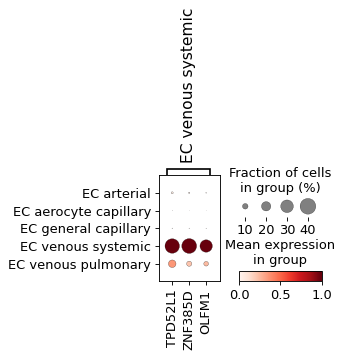

FIBROBLAST LINEAGE pseudobulk:


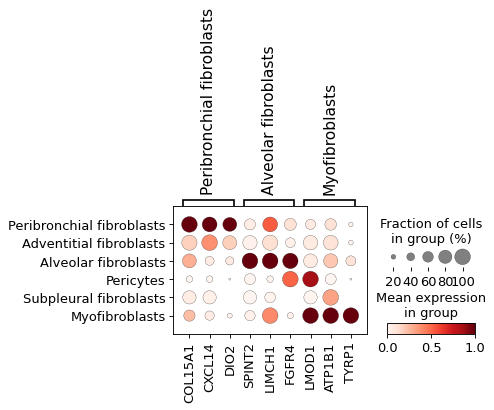

FIBROBLAST LINEAGE cell-level:


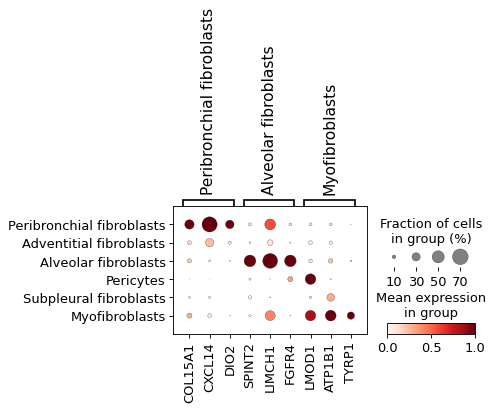

No new markers found/needed for Smooth muscle cell types.
SUBMUCOSAL GLAND pseudobulk:


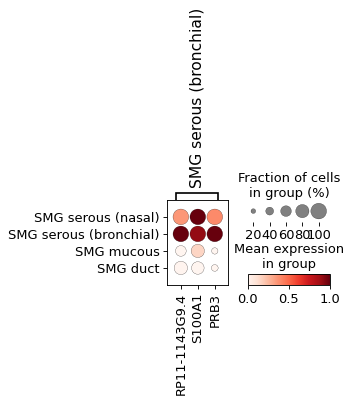

SUBMUCOSAL GLAND cell-level:


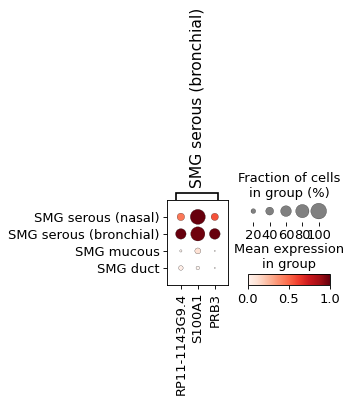

No new markers found/needed for Lymphatic EC cell types.


In [74]:
for lev2ann in lev2_anns_without_markers:
    cts_to_keep = [
        ct
        for ct in adatas_per_lev2ann[lev2ann].obs[pb_var_2].unique()
        if ct in cts_without_markers_3
    ]
    if len(cts_to_keep) > 0:
        # keep only markers for cts for which we still need markers
        marker_dict = {
            ct: ct_markers
            for ct, ct_markers in zip(
                ct_vs_lev2_markers_loose[lev2ann].keys(),
                ct_vs_lev2_markers_loose[lev2ann].values(),
            )
            if ct in cts_to_keep
        }
        if len(marker_dict) > 0:
            print(lev2ann.upper(), "pseudobulk:")
            sc.pl.dotplot(
                adatas_per_lev2ann[lev2ann],
                var_names=marker_dict,
                groupby=pb_var_2,
                standard_scale="var",
            )
            print(lev2ann.upper(), "cell-level:")
            sc.pl.dotplot(
                adatas_cellular_per_lev2ann[lev2ann],
                var_names=marker_dict,
                groupby=pb_var_2,
                standard_scale="var",
            )
        else:
            print(f"No new markers found/needed for {lev2ann} cell types.")
    else:
        print(f"No new markers found for {lev2ann} cell types.")

In [75]:
cts_without_markers_4 = sorted(
    set(cts_vs_lev2_no_markers_loose) & set(cts_without_markers_3)
)

In [76]:
cts_without_markers_4

['CD4 T cells',
 'Lymphatic EC differentiating',
 'Lymphatic EC mature',
 'Monocyte-derived Mph',
 'Smooth muscle']

Store markers in dataframe:

In [77]:
for lev2ann, lev2_marker_dict in ct_vs_lev2_markers_loose.items():
    # get markers for compartment (=ann_level_1) from which lev2 came:
    comp = lev2_to_comp[lev2ann]
    comp_markers = markers_comps[comp]
    n_comp_markers = len(comp_markers)
    # get markers for lev2 annotation (i.e. not for final annotation but reference)
    lev2_markers = annlev2_markers_per_comp[comp][lev2ann]
    n_lev2_markers = len(lev2_markers)
    # now loop through cts within the lev2 compartment
    for ct, ct_markers in lev2_marker_dict.items():
        if ct in cts_without_markers_3:
            n_ct_markers = len(ct_markers)
            # compartment markers
            marker_df_final[f"{ct}_marker"][:n_comp_markers] = comp_markers
            marker_df_final[f"{ct}_marker_for"][:n_comp_markers] = comp
            marker_df_final[f"{ct}_marker_reference"][:n_comp_markers] = "Full atlas"
            # ann level 2 markers
            marker_df_final[f"{ct}_marker"][
                n_comp_markers : (n_comp_markers + n_lev2_markers)
            ] = lev2_markers
            marker_df_final[f"{ct}_marker_for"][
                n_comp_markers : (n_comp_markers + n_lev2_markers)
            ] = lev2ann
            marker_df_final[f"{ct}_marker_reference"][
                n_comp_markers : (n_comp_markers + n_lev2_markers)
            ] = comp
            # ct markers
            marker_df_final[f"{ct}_marker"][
                (n_comp_markers + n_lev2_markers) : (
                    n_comp_markers + n_lev2_markers + n_ct_markers
                )
            ] = ct_markers
            marker_df_final[f"{ct}_marker_for"][
                (n_comp_markers + n_lev2_markers) : (
                    n_comp_markers + n_lev2_markers + n_ct_markers
                )
            ] = f"{ct} (poss. lowly expressed, non-unique)"
            marker_df_final[f"{ct}_marker_reference"][
                (n_comp_markers + n_lev2_markers) : (
                    n_comp_markers + n_lev2_markers + n_ct_markers
                )
            ] = lev2ann

### Final cts: no filtering beyond rank genes groups filtering as done above, take top 5 markers

In [78]:
cts_vs_lev2_no_markers_no_filtering = dict()
for ct in cts_without_markers_4:
    lev2ann = ct_reference.loc[ct, "Level_2"]
    degs = sc.get.rank_genes_groups_df(
        adatas_per_lev2ann[lev2ann],
        group=ct,
        key=f"{pb_var_2}_vs_lev2ann_loose_filtered",
        log2fc_min=2,
    )
    degs.dropna(how="any", inplace=True)
    cts_vs_lev2_no_markers_no_filtering[ct] = degs.names.values[:5]

In [79]:
cts_vs_lev2_no_markers_no_filtering

{'CD4 T cells': array(['CD40LG', 'TNFRSF25', 'CD28', 'CD4', 'TRAT1'], dtype=object),
 'Lymphatic EC differentiating': array(['UTY', 'KANSL1L', 'NPIPB5', 'UVSSA', 'NBPF9'], dtype=object),
 'Lymphatic EC mature': array(['ISG15', 'ZMAT5', 'CYP1B1', 'FMOD', 'FAM173A'], dtype=object),
 'Monocyte-derived Mph': array(['SPP1', 'HAMP'], dtype=object),
 'Smooth muscle': array(['IFI27', 'HIGD1B', 'ADGRF5', 'HLA-DRA'], dtype=object)}

MYELOID pseudobulk:


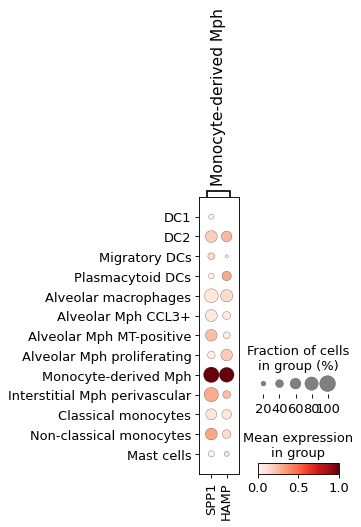

MYELOID cell-level:


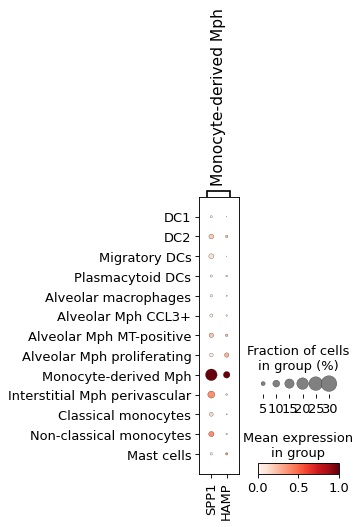

LYMPHOID pseudobulk:


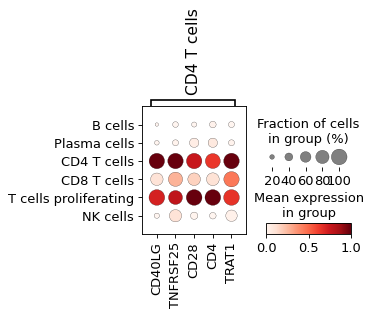

LYMPHOID cell-level:


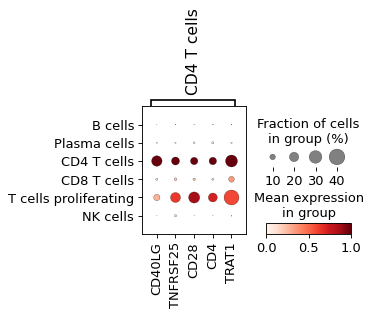

No new markers found for Alveolar epithelium cell types.
No new markers found for Airway epithelium cell types.
No new markers found for Blood vessels cell types.
No new markers found for Fibroblast lineage cell types.
SMOOTH MUSCLE pseudobulk:


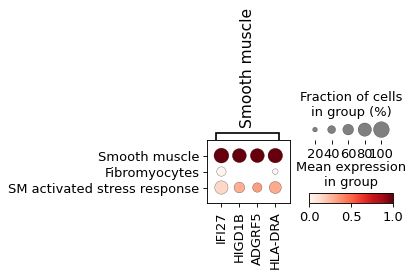

SMOOTH MUSCLE cell-level:


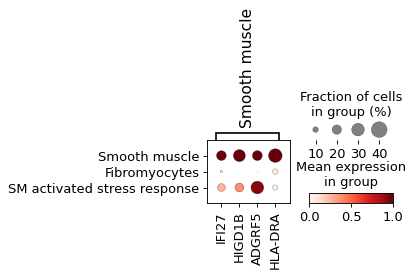

No new markers found for Submucosal Gland cell types.
LYMPHATIC EC pseudobulk:


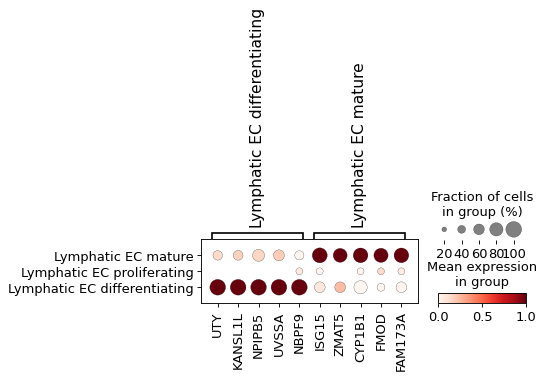

LYMPHATIC EC cell-level:


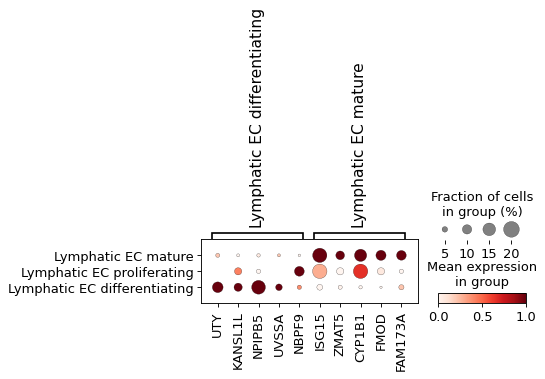

In [80]:
for lev2ann in lev2_anns_without_markers:
    cts_to_keep = [
        ct
        for ct in adatas_per_lev2ann[lev2ann].obs[pb_var_2].unique()
        if ct in cts_vs_lev2_no_markers_no_filtering.keys()
    ]
    if len(cts_to_keep) > 0:
        # keep only markers for cts for which we still need markers
        marker_dict = {
            ct: ct_markers
            for ct, ct_markers in zip(
                cts_vs_lev2_no_markers_no_filtering.keys(),
                cts_vs_lev2_no_markers_no_filtering.values(),
            )
            if ct in cts_to_keep
        }
        if len(marker_dict) > 0:
            print(lev2ann.upper(), "pseudobulk:")
            sc.pl.dotplot(
                adatas_per_lev2ann[lev2ann],
                var_names=marker_dict,
                groupby=pb_var_2,
                standard_scale="var",
            )
            print(lev2ann.upper(), "cell-level:")
            sc.pl.dotplot(
                adatas_cellular_per_lev2ann[lev2ann],
                var_names=marker_dict,
                groupby=pb_var_2,
                standard_scale="var",
            )
        else:
            print(f"No new markers found/needed for {lev2ann} cell types.")
    else:
        print(f"No new markers found for {lev2ann} cell types.")

In [81]:
for final_ct, final_ct_markers in cts_vs_lev2_no_markers_no_filtering.items():
    lev2ann = ct_reference.loc[final_ct, "Level_2"]
    # get markers for compartment (=ann_level_1) from which lev2 came:
    comp = lev2_to_comp[lev2ann]
    comp_markers = markers_comps[comp]
    n_comp_markers = len(comp_markers)
    # get markers for lev2 annotation (i.e. not for final annotation but reference)
    lev2_markers = annlev2_markers_per_comp[comp][lev2ann]
    n_lev2_markers = len(lev2_markers)
    # now add marker info
    n_ct_markers = len(final_ct_markers)
    # compartment markers
    marker_df_final[f"{final_ct}_marker"][:n_comp_markers] = comp_markers
    marker_df_final[f"{final_ct}_marker_for"][:n_comp_markers] = comp
    marker_df_final[f"{final_ct}_marker_reference"][:n_comp_markers] = "Full atlas"
    # ann level 2 markers
    marker_df_final[f"{final_ct}_marker"][
        n_comp_markers : (n_comp_markers + n_lev2_markers)
    ] = lev2_markers
    marker_df_final[f"{final_ct}_marker_for"][
        n_comp_markers : (n_comp_markers + n_lev2_markers)
    ] = lev2ann
    marker_df_final[f"{final_ct}_marker_reference"][
        n_comp_markers : (n_comp_markers + n_lev2_markers)
    ] = comp
    # ct markers
    if (
        final_ct != lev2ann
    ):  # this is to exclude smooth muscle, smooth muscle markers (lev2 and 3)
        marker_df_final[f"{final_ct}_marker"][
            (n_comp_markers + n_lev2_markers) : (
                n_comp_markers + n_lev2_markers + n_ct_markers
            )
        ] = final_ct_markers
        marker_df_final[f"{final_ct}_marker_for"][
            (n_comp_markers + n_lev2_markers) : (
                n_comp_markers + n_lev2_markers + n_ct_markers
            )
        ] = f"{final_ct} (poss. lowly expressed, non-unique, non-universal)"
        marker_df_final[f"{final_ct}_marker_reference"][
            (n_comp_markers + n_lev2_markers) : (
                n_comp_markers + n_lev2_markers + n_ct_markers
            )
        ] = lev2ann

remove empty rows from final marker dataframe:

In [82]:
marker_df_final.dropna(axis=0, how="all", inplace=True)

In [83]:
marker_df_final.loc[
    :, [col for col in marker_df_final.columns if col.startswith("Smooth")]
]

Smooth muscle_marker Smooth muscle_marker_for  \
0                COL1A2                   Stroma   
1                   DCN                   Stroma   
2                 MFAP4                   Stroma   
3                 MYH11            Smooth muscle   
4               TINAGL1            Smooth muscle   
5                   PLN            Smooth muscle   
6                   NaN                      NaN   
7                   NaN                      NaN   
8                   NaN                      NaN   
9                   NaN                      NaN   
10                  NaN                      NaN   

   Smooth muscle_marker_reference  
0                      Full atlas  
1                      Full atlas  
2                      Full atlas  
3                          Stroma  
4                          Stroma  
5                          Stroma  
6                             NaN  
7                             NaN  
8                             NaN  
9                             NaN  
10                            NaN

## Manually edit markers for cell types with too few samples 

In [ ]:
marker_df_final = pd.read_csv(path_marker_genes, index_col=0)

(i.e. Lymphatic EC differentiating and proliferating are at low cell numbers, and diff. mostly from a single subject (others do not pass min_n_cell bars), which messes up the pseudobulk approach (a single pseudobulk left))

In [24]:
proposed_markers = {
    "Lymphatic EC mature": ["LYVE1", "CCL21"],
    "Lymphatic EC differentiating": ["PROX1", "PKHD1L1", "FLT4", "SEMA3D"],
    "Lymphatic EC proliferating": ["MKI67", "TOP2A"],
}

plot proposed markers in figure to see if they are actually good markers:

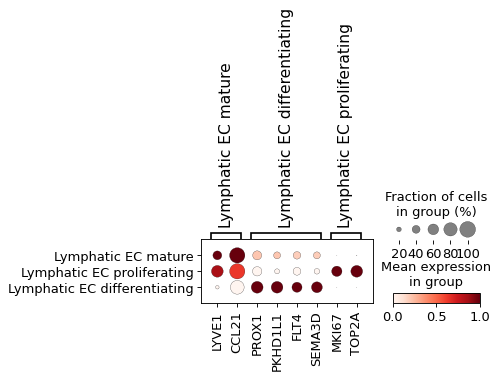

In [25]:
sc.pl.dotplot(
    adata=adata[adata.obs.ann_level_2 == "Lymphatic EC"],
    groupby="manual_ann",
    var_names=proposed_markers,
    standard_scale="var",
)

In [26]:
for ct, proposed_ct_markers in proposed_markers.items():
    # check which rows contain markers we want to replace
    ct_rows_to_update = np.where(
        marker_df_final[f"{ct}_marker_for"].str.startswith(ct)
    )[0]
    # set those values to np.nan first
    marker_df_final.loc[ct_rows_to_update, f"{ct}_marker"] = np.nan
    marker_df_final.loc[ct_rows_to_update, f"{ct}_marker_for"] = np.nan
    # now fill in with new markers:
    n_new_markers = len(proposed_ct_markers)
    marker_df_final.loc[
        ct_rows_to_update[:n_new_markers], f"{ct}_marker"
    ] = proposed_ct_markers
    marker_df_final.loc[
        ct_rows_to_update[:n_new_markers], f"{ct}_marker_for"
    ] = f"{ct} (manually added)"
    # and set reference column to nan for rows without markers:
    marker_df_final.loc[
        ct_rows_to_update[n_new_markers:], f"{ct}_marker_reference"
    ] = np.nan

## Plot and store final markers:

Final marker dotplot:

In [27]:
final_markers_dict = {
    col: marker_df_final[col].dropna().values
    for col in marker_df_final.columns
    if col.endswith("_marker")
}

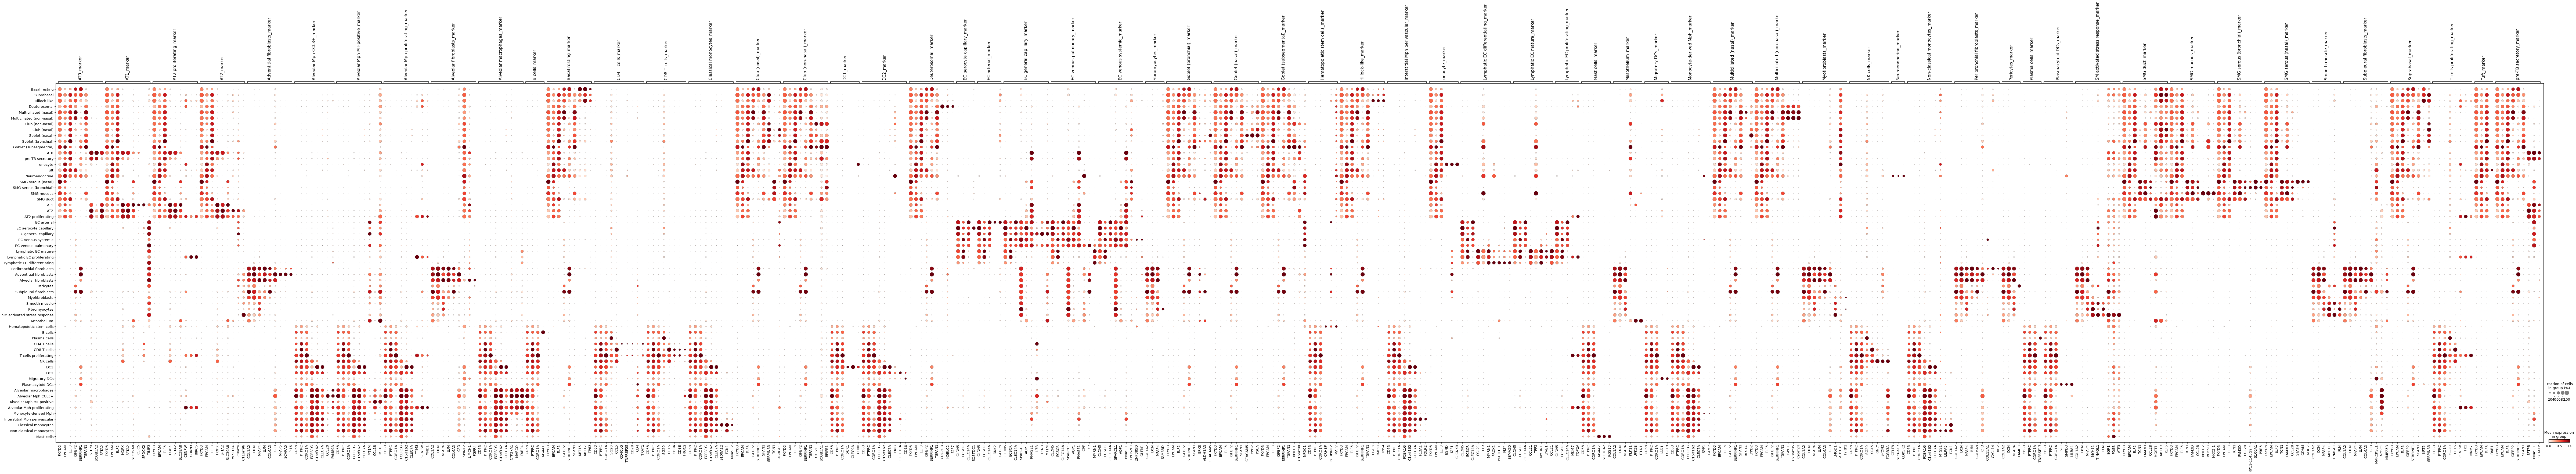

In [32]:
fig, ax = plt.subplots(figsize=(150, 23))
sc.pl.dotplot(
    adata,
    var_names=final_markers_dict,
    groupby="manual_ann",
    standard_scale="var",
    ax=ax,
)

In [33]:
fig.savefig(
    os.path.join(dir_figures, "final_markers.png"),
    bbox_inches="tight",
    dpi=140,
    transparent=True,
)

In [34]:
marker_df_final.to_csv(path_marker_genes)